# Set up the notebook

In [2]:
# @title Setting up variables
job_config = {}
# BASE_PATH = '/Users/morgunov/batista/Summer/pipeline/'
BASE_PATH = '/content/drive/MyDrive/Generative_ML/current_data/' #@param {type:"string"}
PROTEIN_NAME = 'HNH.pdb' # @param {type:"string"}
RANDOM_SEED = 42
MODE = 'Active Learning' #@param ["Pretraining", "Active Learning"]
RANDOM_SAMPLING = True #@param {type:"boolean"}
# @markdown select the name of the smiles-containing column in the training dataframe. use CAPS if pretraining on MOSES
SMILES_KEY = "smiles" #@param ["smiles", "SMILES"]
# @markdown following variables are only relevant when doing pretraining
TRAIN_FNAME = "moses_and_binding_no_rare_tokens_train.csv.gz" #@param ["moses_and_binding_no_rare_tokens_train.csv.gz", "moses_train.csv.gz"] {allow-input: true}
VAL_FNAME = "moses_and_binding_no_rare_tokens_test.csv.gz" #@param ["moses_and_binding_no_rare_tokens_test.csv.gz", "moses_test.csv.gz"] {allow-input: true}
TRAIN_CKPT_NAME = 'model1_random_al1' # @param {type:"string"}
CURRENT_CYCLE_PREFIX = "model1_random_al1" #@param {type:"string"}

if MODE == 'Pretraining':
    job_config.update({'lr_warmup': True, 'lr_decay': True, 'epochs': 30, 'learning_rate': 3e-4,})
elif MODE == 'Active Learning':
    job_config.update({'lr_warmup': False, 'lr_decay': True, 'epochs': 10, 'learning_rate': 3e-5,})
else:
    raise KeyError(f'requested {MODE} but only Pretraining and Active Learning are supported')
print(f'Based on the selected mode ({MODE}) the following values will be used in CONFIG_DICT', job_config, "\nDon't forget to reinitialize CONFIG_DICT!")

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Based on the selected mode (Active Learning) the following values will be used in CONFIG_DICT {'lr_warmup': False, 'lr_decay': True, 'epochs': 10, 'learning_rate': 3e-05} 
Don't forget to reinitialize CONFIG_DICT!
Mounted at /content/drive


In [3]:
#@title Set up paths
import torch
import os
PRETRAINING_PATH = BASE_PATH + '1. Pretraining/'
GENERATION_PATH = BASE_PATH + '2. Generation/'
SAMPLING_PATH = BASE_PATH + '3. Sampling/'
DIFFDOCK_PATH = BASE_PATH + '4. DiffDock/'
SCORING_PATH = BASE_PATH + '5. Scoring/'
AL_PATH = BASE_PATH + '6. ActiveLearning/'

PROTEIN_PATH = DIFFDOCK_PATH + 'proteins/' + PROTEIN_NAME

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
REGEX_PATTERN = "(\[[^\]]+]|<|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|@@|\?|>|!|~|\*|\$|\%[0-9]{2}|[0-9])"

In [4]:
#@title initialize CONFIG_DICT
CONFIG_DICT = {
    "device": DEVICE,
    "att_bias": False,
    "gpt_bias": True,
    "att_drop_rate": 0.1,
    "gpt_drop_rate": 0.1,
    "n_layer": 8,
    "n_head": 8,
    "n_embed": 256,
    "ff_mult": 4, # multiplier for Feed Forward number of hidden units inside multihead,
    "doGELU": True, # else ReLU
    "attention_times": [],
    "do_flash": True,
    "smiles_key": SMILES_KEY,
    "wandb_project": f'BetaPipeline',
    "slice_data": False, #False for all data
    "batch_size": 512, #512,
    "betas": (0.965, 0.99), #(0.9, 0.95)
    "rho": 0.04, # For SophiaG
    "weight_decay": 0.1,
    "num_workers": 0 # number of worker processes to use for loading data
}
CONFIG_DICT.update(job_config)

In [5]:
#@title Run this cell to ensure the variables below are set the way you want them to be!
pretrain_config = {
    "train_path": f"{PRETRAINING_PATH}datasets/{TRAIN_FNAME}",
    "val_path": f"{PRETRAINING_PATH}datasets/{VAL_FNAME}",
    "wandb_runname": TRAIN_CKPT_NAME,
    }

# @markdown the following setting is relevant only when loading AL descriptors
DATASET_DESC_FNAME = "model1_baseline_random_threshold11" #@param ["model1_baseline_threshold11_softmax_sub", "model1_softsub_al1_threshold11_softmax_sub", "model1_baseline_random_threshold11"]

if MODE == 'Pretraining':
    pretrain_config.update({
        "save_ckpt_path": f"{PRETRAINING_PATH}model_weights/{TRAIN_CKPT_NAME}.pt",
        "desc_path": f"{PRETRAINING_PATH}dataset_descriptors/{TRAIN_FNAME.split('.')[0][:-6]}.yaml",
        })
elif MODE == 'Active Learning':
    pretrain_config.update({
        "save_ckpt_path": f"{AL_PATH}model_weights/{TRAIN_CKPT_NAME}.pt",
        "desc_path": f"{AL_PATH}dataset_descriptors/{DATASET_DESC_FNAME}.yaml"
        })


print('Model will be trained on\n', '/'.join(pretrain_config['train_path'].split('/')[6:]))
print('... and validated on\n', '/'.join(pretrain_config['val_path'].split('/')[6:]))
print('... dataset descriptors will be saved to\n', '/'.join(pretrain_config['desc_path'].split('/')[6:]))
print('... model weights will be saved to\n', '/'.join(pretrain_config['save_ckpt_path'].split('/')[6:]))
print('... wandb run will be named', TRAIN_CKPT_NAME)
CONFIG_DICT.update(pretrain_config)

Model will be trained on
 1. Pretraining/datasets/moses_and_binding_no_rare_tokens_train.csv.gz
... and validated on
 1. Pretraining/datasets/moses_and_binding_no_rare_tokens_test.csv.gz
... dataset descriptors will be saved to
 6. ActiveLearning/dataset_descriptors/model1_baseline_random_threshold11.yaml
... model weights will be saved to
 6. ActiveLearning/model_weights/model1_random_al1.pt
... wandb run will be named model1_random_al1


# GPT

## Imports & Installations

In [ ]:
# install necessary packages
!pip install rdkit
!pip install pandas==1.5.3
!pip install wandb

# clone Sophia optimizer GitHub repository
!git clone https://github.com/Liuhong99/Sophia.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=5c474ec502b44a591da52a1d5d0e61cbcaa754fd473351fde52954024efd2276
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
Cloning into 'Sophia'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 139 (delta 11), reused 13 (delta 10), pack-reused 120
Receiving objects: 100% (139/139), 280.5

In [ ]:
# import necessary packages
import numpy as np
import os
import re
import logging
import wandb
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim
from torch.cuda.amp import GradScaler
from tqdm import tqdm
from rdkit import Chem
from Sophia.sophia import SophiaG
import yaml
import pandas as pd

# set random seed for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

## Definitions

In [ ]:
class GPTConfig:
    def __init__(self, vocab_size=None, block_size=None, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

    def export_attributes(self, export_path):
        with open(export_path, 'w') as f:
            yaml.dump(vars(self), f)

    def load_attributes(self, load_path):
        with open(load_path, 'r') as f:
            config_dict = yaml.load(f, Loader=yaml.SafeLoader)
        self.__dict__.update(config_dict)

### Dataset loading & sampling

In [ ]:
@torch.no_grad()
def sample(model, x, steps, temperature=1.0):
    block_size = model.get_block_size() # define size of context window used for input conditioning
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # limit conditioning input to the most recent block_size elements
        logits, _= model(x_cond) # give input to model and get logits (unnormalized scores or probabilities)
        logits = logits[:, -1, :] / temperature # extract the logits for the next token in the sequence
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, 1)
        x = torch.cat((x, ix), dim=1) # concatenate the chosen token index with the existing sequence
    return x

def check_novelty(gen_smiles, train_smiles):
    if len(gen_smiles) == 0:
        novel_ratio = 0
    else:
        duplicates = [1 for mol in gen_smiles if mol in train_smiles]
        novel = len(gen_smiles) - sum(duplicates)
        novel_ratio = novel*100/len(gen_smiles)
    return novel_ratio

def canonic_smiles(smiles_or_mol):
    mol = get_mol(smiles_or_mol)
    if mol is None:
        return None
    return Chem.MolToSmiles(mol)


class SMILESDataset(Dataset):

    def __init__(self, data=None, chars=None, block_size=None, len_data = None):
        if chars is None:
            self.desc_only = True
            return
        self.desc_only = False
        self.vocab = set(chars)
        self.vocab_size = len(chars)
        self.stoi = {ch:i for i,ch in enumerate(chars)}
        # self.stoi['<'] = -100
        self.itos = {i:s for s,i in self.stoi.items()}
        # self.itos = {i:ch for i,ch in enumerate(chars)}

        self.block_size = block_size
        self.data = data
        self.len_data = len_data

    def export_desc_attributes(self, export_path):
        attr_dict = {
            "desc_only": self.desc_only,
            "vocab_size": self.vocab_size,
            "block_size": self.block_size,
            "stoi": self.stoi,
            "itos": self.itos,
            "len_data": self.len_data
        }
        with open(export_path, 'w') as f:
            yaml.dump(attr_dict, f)

    def load_desc_attributes(self, load_path):
        with open(load_path, 'r') as f:
            attr_dict = yaml.load(f, Loader=yaml.SafeLoader)
        self.__dict__.update(attr_dict)

    def __len__(self):
        assert not self.desc_only, "Dataset is not initialized"
        return len(self.data)

    def __getitem__(self, idx):
        assert not self.desc_only, "Dataset is not initialized"
        smiles = self.data[idx].strip()
        # define regular expressin pattern used to identify characters in the SMILES strings
        regex = re.compile(REGEX_PATTERN)
        smiles_matches = regex.findall(smiles)

        # smiles = str('!') + smiles
        # smiles += str('<')*(self.block_size - len(smiles_matches)) # pad SMILES string by appending '<' to the end until self.block_size is achieved

        if len(smiles_matches) > self.block_size+1: # if the number of matches found by the regular expression pattern applied to the SMILES string exceeds self.block_size:
            smiles = smiles[:self.block_size+1]

        embedded_smile = [self.stoi[s] for s in smiles_matches]
        x = torch.tensor(embedded_smile[:-1], dtype=torch.long)
        y = torch.tensor(embedded_smile[1:], dtype=torch.long)
        return x, y


### Model

In [ ]:
class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embed % config.n_head == 0
        self.config = config

        self.query = nn.Linear(config.n_embed, config.n_embed, bias=config.att_bias)
        self.key = nn.Linear(config.n_embed, config.n_embed, bias=config.att_bias)
        self.value = nn.Linear(config.n_embed, config.n_embed, bias=config.att_bias)

        self.attn_drop = nn.Dropout(config.att_drop_rate)
        self.resid_drop = nn.Dropout(config.att_drop_rate)

        self.proj = nn.Linear(config.n_embed, config.n_embed)
        self.n_head = config.n_head

        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                .view(1, 1, config.block_size, config.block_size))

    def forward(self, x, layer_past=None):
        B, T, C = x.size()
        # apply attention functions to get tensors with dimensions (B, n_head, T, head_size)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head)
        k = self.key(x).view(B, T, self.n_head, C // self.n_head)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head)
        if self.config.do_flash:
            q = q.transpose(1, 2)
            k = k.transpose(1, 2)
            v = v.transpose(1, 2)
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, dropout_p=self.config.att_drop_rate if self.training else 0, is_causal=True)
            y = y.transpose(1, 2)
        else:
            # (B h T s) @ (B h s T) -> (B h T T)
            att = torch.einsum('bths,bihs->bhti', q, k) / np.sqrt(k.size(-1))
            att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            # (B h T T) @ (B h T s) -> (B h T s)
            y = torch.einsum('bhtq,bqhs->bths', att, v)
            self.att_weights = att
        self.attended = y
        y = y.contiguous().view(B, T, C)
        y = self.resid_drop(self.proj(y))
        self.out = y
        return y

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embed)
        self.ln2 = nn.LayerNorm(config.n_embed)
        self.attn = SelfAttention(config)
        self.mlp = nn.Sequential(nn.Linear(config.n_embed, config.ff_mult*config.n_embed), nn.GELU() if config.doGELU else nn.ReLU(),
            nn.Linear(config.ff_mult*config.n_embed, config.n_embed), nn.Dropout(config.att_drop_rate))

    def forward(self, x):
        y = self.attn(self.ln1(x))
        x = x + y # perform a residual connection by summing input and attention output
        x = x + self.mlp(self.ln2(x)) # apply layer normalization and then MLP, create a residual connection with input
        return x

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embed)
        self.type_emb = nn.Embedding(2, config.n_embed)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embed))

        self.drop = nn.Dropout(config.gpt_drop_rate)
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])

        self.ln_f = nn.LayerNorm(config.n_embed)
        self.head = nn.Linear(config.n_embed, config.vocab_size, bias=config.gpt_bias)
        self.block_size = config.block_size # define the context size
        self.apply(self._init_weights) # initialize weights and apply to all relevant modules in the model

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def configure_optimizers(self, train_config):
        decay, no_decay = set(), set()
        no_decay = set()

        whitelist_weight_modules = (torch.nn.Linear)
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        # for named module of the model:
        for mn, m in self.named_modules():
            # for named parameter of each module:
            for pn, p in m.named_parameters():
                # construct full parameter name by concatenating module name and parameter name, separated by a dot
                fpn = '%s.%s' % (mn, pn) if mn else pn
                if pn.endswith('bias') or ('bias' in pn):
                    no_decay.add(fpn)
                elif (pn.endswith('weight') or ('weight' in pn)) and isinstance(m, whitelist_weight_modules):
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    no_decay.add(fpn)
        no_decay.add('pos_emb')
        param_dict = {pn:p for pn, p in self.named_parameters()}
        assert len(decay & no_decay) == 0
        # assert that all parameters from both sets have been correctly separated
        assert len(param_dict.keys() - (decay | no_decay)) == 0
        optim_groups = [{"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
                        {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0}]
        optimizer = SophiaG(optim_groups, lr=train_config.learning_rate, betas=train_config.betas, rho=train_config.rho, weight_decay=train_config.weight_decay)
        return optimizer

    def forward(self, idx, targets=None, prop = None, scaffold = None):
        b, t = idx.size()

        assert t <= self.block_size

        token_embeddings = self.tok_emb(idx) # pass input tensor through token embedding layer
        # select a subset of the position embedding matrix based on the length of the input sequence
        position_embeddings = self.pos_emb[:, :t, :]
        # pass a tensor of ones of shape (b, t) through the type embedding layer,
        # maps a binary type indicator to a learnable embedding vector, all type indicators
        # are set to 1, indicating same type for all tokens in input sequence
        type_embeddings = self.type_emb(torch.ones((b,t), dtype=torch.long, device=idx.device))
        x = self.drop(token_embeddings + position_embeddings + type_embeddings)

        for layer in self.blocks:
            x = layer(x)
        x = self.ln_f(x)
        logits = self.head(x)
        loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.view(-1), ignore_index=self.config.loss_ignore_index) if targets is not None else None
        # loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.view(-1)) if targets is not None else None
        return logits, loss

### Training

In [ ]:
class Trainer:

    def __init__(self, model, train_dataset, test_dataset=None):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = model.config
        self.stoi = train_dataset.stoi
        self.itos = train_dataset.itos

    def train(self, wandb):
        model, config = self.model, self.config
        optimizer = model.configure_optimizers(config)
        scaler = GradScaler() # define variable used for gradient scaling in mixed-precision training
        self.tokens = 0 # initialize a counter used for learning rate decay

        def run_epoch(split):
            is_train = split == 'train'
            model.train(is_train)
            data = self.train_dataset if is_train else self.test_dataset
            loader = DataLoader(data, shuffle=True, pin_memory=True, batch_size=config.batch_size, num_workers=config.num_workers)
            losses = []
            pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
            # for batch index, batch in progress bar:
            for it, (x, y) in pbar:
                # move the input data tensor, target data tensor, property tensor, and scaffold tensor to GPU
                x, y = x.to(config.device), y.to(config.device)
                # allow model to use lower-precision computations for improved memory usage
                if config.device == 'cuda':
                    with torch.cuda.amp.autocast():
                        with torch.set_grad_enabled(is_train):
                            logits, loss = model(x, y)
                            loss = loss.mean()
                            losses.append(loss.item())
                else:
                    with torch.cpu.amp.autocast():
                        with torch.set_grad_enabled(is_train):
                            logits, loss = model(x, y)
                            loss = loss.mean()
                            losses.append(loss.item())

                if is_train:
                    model.zero_grad()
                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer) # unscale the gradients of the optimizer's parameters to their original values
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip gradients of model parameters to prevent them from exploding, setting maximum gradient norm to be 1.0
                    scaler.step(optimizer) # update the optimizer's parameters based on calculated gradients
                    scaler.update() # update the scale factor of the gradient scaler
                    if config.lr_decay:
                        self.tokens += (y >= 0).sum() # increment the number of processed tokens by the count of valid tokens (not padding or special tokens)
                        if config.lr_warmup and self.tokens < config.warmup_tokens:
                            lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens)) # perform a linear warm-up
                        else:
                            baseline = config.warmup_tokens if config.lr_warmup else 0
                            # calculate the progress of training in terms of the number of tokens processed
                            progress = float(self.tokens - baseline) / float(max(1, config.final_tokens - baseline))
                            # calculate the scaling factor for the learning rate (between 0.1 and 1.0)
                            # to gradually reduce learning rate as training progresses
                            lr_mult = max(0.1, 0.5 * (1.0 + np.cos(np.pi * progress)))
                        lr = config.learning_rate * lr_mult # multiply the base learning rate by the scaling factor to obtain the updated learning rate
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                    else:
                        lr = config.learning_rate
                    if wandb is not None: # log training progress using Weights & Biases
                        wandb.log({'step_train_loss': loss, 'train_step': it + epoch*len(loader), 'learning_rate': lr})
                    # update the description of the progress bar with epoch, iteration, and training loss
                    pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. lr {lr:e}")
            return float(np.mean(losses))

        # initialize best loss as infinity
        best_loss = float('inf')
        for epoch in range(config.epochs):
            print(f'{epoch=}')
            train_loss = run_epoch('train')
            log_dict = {'epoch_train_loss': train_loss, 'epoch': epoch + 1}
            if self.test_dataset is not None:
                test_loss = run_epoch('test')
                log_dict['epoch_valid_loss'] = test_loss
            if wandb is not None:
                wandb.log(log_dict)
            good_model = False
            if self.test_dataset is None:
                good_model = True
            else:
                if test_loss < best_loss:
                    best_loss = test_loss
                    good_model = True
            if good_model:
                torch.save(self.model.state_dict(), self.config.save_ckpt_path)

In [ ]:
def load_data(config_dict, mode='pretrain', forced_block_size=None, forced_vocab=None):
    if mode == 'pretrain':
        if 'gz' in config_dict["train_path"]:
            compression = 'gzip'
        else:
            compression = None
        if (cut:=config_dict["slice_data"]):
            train_data = pd.read_csv(config_dict["train_path"], compression=compression)[:cut]
            val_data = pd.read_csv(config_dict["val_path"], compression=compression)[:cut]
        else:
            train_data = pd.read_csv(config_dict["train_path"], compression=compression)
            val_data = pd.read_csv(config_dict["val_path"], compression=compression)
        iterators = (train_data[config_dict['smiles_key']].values, val_data[config_dict['smiles_key']].values)
        assert len(train_data) == len(train_data[config_dict['smiles_key']].values), "There's no reason why this shouldn't be true"
    elif mode == 'al':
        print(f"Loading AL dataset from", '/'.join(config_dict["al_path"].split('/')[6:]))
        al_data = pd.read_csv(config_dict["al_path"])
        iterators = (al_data[config_dict['smiles_key']].values, )
    else:
        raise KeyError(f"Only pretraining and active learning are currently supported")

    # smiles = train_data[config_dict['smiles_key']]
    # vsmiles = val_data[config_dict['smiles_key']]

    # compile pattern into a regular expression object that can be used for matching operations
    regex = re.compile(REGEX_PATTERN)
    char_set = {'<', '!', '~'} # context={'<'}
    # char_set = {'<', '!'} # context={'<'}

    max_len = 0
    for iterator in iterators:
        for i in iterator:
            chars = regex.findall(i.strip())
            max_len = max(max_len, len(chars))
            for char in chars:
                char_set.add(char)

    chars = sorted(list(char_set))
    max_len += 1    #accounting for the start token, which hasn't been added yet
    if forced_block_size is not None:
        assert mode == 'al', "Cannot force a block size in pretraining"
        max_len = forced_block_size
    if forced_vocab is not None:
        assert mode == 'al', "Cannot force a vocabulary in pretraining"
        chars = sorted(list(forced_vocab))

    datasets = []
    for iterator in iterators:
        padded = ['!' + i + '~' + '<'*(max_len - 1 - len(regex.findall(i.strip()))) for i in iterator]
        dataset = SMILESDataset(data=padded, chars=chars, block_size=max_len, len_data=len(iterator))
        datasets.append(dataset)
    dataset.export_desc_attributes(config_dict["desc_path"])
    return datasets

    # smiles = ['!' + i + '~' + '<'*(max_len - 1 - len(regex.findall(i.strip()))) for i in smiles]
    # vsmiles = ['!' + i + '~' + '<'*(max_len - 1 - len(regex.findall(i.strip()))) for i in vsmiles]

    # train_dataset = SMILESDataset(data=smiles, chars=chars, block_size=max_len, len_data=len(train_data))
    # valid_dataset = SMILESDataset(data=vsmiles, chars=chars, block_size=max_len, len_data=len(val_data))
    # train_dataset.export_desc_attributes(config_dict["desc_path"])
    # return train_dataset, valid_dataset

In [ ]:
def train_GPT(train_dataset, config_dict, valid_dataset=None, load_ckpt=False):
  """
  OUTPUTS:
  1) checkpoint of trained model parameters
  2) Weights & Biases logged run
  """

  mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                    warmup_tokens=0.1*train_dataset.len_data*train_dataset.block_size,
                    final_tokens=config_dict["epochs"]*train_dataset.len_data*train_dataset.block_size,
                    loss_ignore_index=train_dataset.stoi['<'],
                    **config_dict)
  model = GPT(mconf)
  if load_ckpt:
    model.load_state_dict(torch.load(config_dict['load_ckpt_path']))
  model.to(config_dict["device"])
  torch.compile(model)
  trainer = Trainer(model, train_dataset, valid_dataset)

  %env WANDB_EXECUTABLE=python3
  wandb.init(project=config_dict["wandb_project"], name=config_dict["wandb_runname"])
  trainer.train(wandb=wandb)
  return model, trainer, wandb

## Pretraining

In [ ]:
train_dataset, val_dataset = load_data(CONFIG_DICT) # takes ~1 min
print(train_dataset.vocab_size, train_dataset.block_size)
# (190, 131) for combined
# (26, 55) for MOSES
# (27, 55) MOSES + end token
# (45, 131) MOSES + bindingdb + end token

In [ ]:
model = train_GPT(
                train_dataset = train_dataset,
                valid_dataset = val_dataset,
                config_dict = CONFIG_DICT
        )
#GK wandb API Key: c99c9a01523f93287716691fa3360b1f4566e115
#RB wandb API Key: 4d3d628c6b5a4b3554c7a89ea50df8a4a6be0f85
#AM wandb API key: 5be14d5930441de4707f6a58e4f7c2e229dab1d1

# Inference (Generation)

In [6]:
# @title Run this cell and check all parameters!
CONTEXT = "!" # @param {type:"string"}
TEMPERATURE = 1.0 #@param {type:"slider", min:0, max:2, step:0.1}
VAL_FNAME = "moses_and_binding_no_rare_tokens_test.csv.gz"
LOAD_CKPT_NAME = "model1_random_al1.pt" #@param ["GPT_pretrain_07_14_23:39_1end_ignore_moses+bindingdb.pt", "model1_random_al1.pt"] {allow-input: true}
NUM_TO_GENERATE = 100_000 #@param
PREVIOUSLY_SCORED_MOLS = [] # ["model1_baseline.csv", "model1_softsub_al1.csv"] #@param #"model1_softsub_al2.csv"
PREVIOUS_AL_TRAIN_SETS = [] #["model1_baseline_threshold11_softmax_sub.csv", 'model1_softsub_al1_threshold11_softmax_sub.csv',] #@param #'model1_softsub_al2_threshold11_softmax_sub.csv'
# @markdown Please use the following naming scheme: "model1_al{round of AL}"
# GENERATION_FNAME = "model1_al1" #@param {type:"string"}
#
if MODE == 'Pretraining':
    LOAD_CKPT_PATH = f"{PRETRAINING_PATH}model_weights/{LOAD_CKPT_NAME}"
elif MODE == 'Active Learning':
    LOAD_CKPT_PATH = f"{AL_PATH}model_weights/{LOAD_CKPT_NAME}"
else:
    raise KeyError(f'requested {MODE} but only Pretraining and Active Learning are supported')

inference_parameters = {
    "batch_size": 64,
    "gen_size": NUM_TO_GENERATE,
    "generation_context": CONTEXT,
    "load_ckpt_path": LOAD_CKPT_PATH,
}
CONFIG_DICT.update({
    "generation_path": f"{GENERATION_PATH}smiles/{CURRENT_CYCLE_PREFIX}",
    "diffdock_scored_path_list": [f"{SCORING_PATH}scored_dataframes/{i}" for i in PREVIOUSLY_SCORED_MOLS],
    "al_trainsets_path_list": [f"{AL_PATH}training_sets/{i}" for i in PREVIOUS_AL_TRAIN_SETS],
    "inference_temp": TEMPERATURE,})
print("Generation will use the following dataset descriptors\n", '/'.join(CONFIG_DICT['desc_path'].split('/')[6:]))
print("... and following model weights\n", '/'.join(inference_parameters['load_ckpt_path'].split('/')[6:]))
print("... and molecules will be saved to\n", '/'.join(CONFIG_DICT['generation_path'].split('/')[6:])+ f"_temp{TEMPERATURE}_processed" +'.csv')
print("... already scored molecules will be read from\n", ['/'.join(i.split('/')[6:]) for i in CONFIG_DICT['diffdock_scored_path_list']])
print("... AL training sets will be read from\n", ['/'.join(i.split('/')[6:]) for i in CONFIG_DICT['al_trainsets_path_list']])

Generation will use the following dataset descriptors
 6. ActiveLearning/dataset_descriptors/model1_baseline_random_threshold11.yaml
... and following model weights
 6. ActiveLearning/model_weights/model1_random_al1.pt
... and molecules will be saved to
 2. Generation/smiles/model1_random_al1_temp1.0_processed.csv
... already scored molecules will be read from
 []
... AL training sets will be read from
 []


## Code

### Definitions

In [ ]:
def export_metrics_to_workbook(metrics, fname):
    metric_to_col = {
        'generated': 'B',
        'valid': 'C',
        'unique': 'D',
        'validity': 'E',
        '% unique (rel. to generated)': 'F',
        '% unique (rel. to valid)': 'G',
        '% novelty (rel. to train set)': 'H',
        '% novelty (rel. to train+AL sets)': 'I',
        '% repetitions (from AL0 training set)': 'J',
        '% repetitions (from AL1 training set)': 'K',
        '% repetitions (from AL2 training set)': 'L',
        '% repetitions (from AL3 training set)': 'M',
        '% repetitions (from AL4 training set)': 'N',
        '% repetitions (from AL5 training set)': 'O',
        '% repetitions (from AL6 training set)': 'P',
        '% repetitions (from AL7 training set)': 'Q',
        '% repetitions (from scored from round 0)': 'R',
        '% repetitions (from scored from round 1)': 'S',
        '% repetitions (from scored from round 2)': 'T',
        '% repetitions (from scored from round 3)': 'U',
        '% repetitions (from scored from round 4)': 'V',
        '% repetitions (from scored from round 5)': 'W',
        '% repetitions (from scored from round 6)': 'X',
        '% repetitions (from scored from round 7)': 'Y',
        '% fraction of AL0 training set in generated': 'Z',
        '% fraction of AL1 training set in generated': 'AA',
        '% fraction of AL2 training set in generated': 'AB',
        '% fraction of AL3 training set in generated': 'AC',
        '% fraction of AL4 training set in generated': 'AD',
        '% fraction of AL5 training set in generated': 'AE',
        '% fraction of AL6 training set in generated': 'AF',
        '% fraction of AL7 training set in generated': 'AG',
        '% fraction of scored from round 0 in generated': 'AH',
        '% fraction of scored from round 1 in generated': 'AI',
        '% fraction of scored from round 2 in generated': 'AJ',
        '% fraction of scored from round 3 in generated': 'AK',
        '% fraction of scored from round 4 in generated': 'AL',
        '% fraction of scored from round 5 in generated': 'AM',
        '% fraction of scored from round 6 in generated': 'AN',
        '% fraction of scored from round 7 in generated': 'AO'}
    # Load an excel workbook, open sheet "generated_logbook", find the first nonempty row and append the metrics to that row
    from openpyxl import load_workbook
    wb = load_workbook(filename = f"{BASE_PATH}Generative_ML Logbook.xlsx")
    for i, sheet in enumerate(('generated_logbook_abs', 'generated_logbook_rel')):
        ws = wb[sheet]
        row = 3
        while ws[f'A{row}'].value is not None:
            row += 1
        ws[f'A{row}'] = fname
        for metric, value in metrics.items():
            if isinstance(value, str) and '=' in value:
                if i == 0:
                    value = value.split(' = ')[0].split(' * ')[1]
                else:
                    value = value.split(' = ')[1]
            ws[f'{metric_to_col[metric]}{row}'] = value
    wb.save(filename = f"{BASE_PATH}Generative_ML Logbook.xlsx")

from rdkit import Chem

def get_mol(smile_string):
    mol = Chem.MolFromSmiles(smile_string)
    if mol is None:
        return None
    try:
        Chem.SanitizeMol(mol)
    except ValueError:
        return None
    return mol

def check_novelty(generated, train_list, sig_digs=3, multiplier=100, denominator=None, subtracted=True, show_work=False):
    total_train = set()
    for train in train_list:
        total_train = total_train | train
    repeated = generated & total_train
    if denominator is None:
        denominator = len(generated)
    if subtracted:
        if show_work:
            out = np.round(multiplier*(1-len(repeated)/denominator), sig_digs)
            return f"{multiplier}*(1-{len(repeated)}/{denominator}) = {out}"
        else:
            return np.round(multiplier*(1-len(repeated)/denominator), sig_digs)
    else:
        if show_work:
            out = np.round(multiplier*len(repeated)/denominator, sig_digs)
            return f"{multiplier} * {len(repeated)}/{denominator} = {out}"
        else:
            return np.round(multiplier*len(repeated)/denominator, sig_digs)

def dump_dic_to_text(dic, path, header=None):
    with open(path, 'w') as f:
        if header is not None:
            f.write(f"{header}\n")
        for key, value in dic.items():
            f.write(f'{key}: {value}\n')

def generate_SMILES(config_dict, inference_parameters):
    regex = re.compile(REGEX_PATTERN)
    dataset = SMILESDataset()
    dataset.load_desc_attributes(config_dict["desc_path"])

    mconf = GPTConfig(dataset.vocab_size, dataset.block_size, **config_dict)
    model = GPT(mconf).to(config_dict["device"])
    model.load_state_dict(torch.load(inference_parameters["load_ckpt_path"], map_location=torch.device(config_dict["device"])))
    model.to(config_dict["device"])
    torch.compile(model)

    # load parameters into the model
    block_size = model.get_block_size()
    assert (block_size == dataset.block_size), "Warning: model block size and dataset block size are different"
    molecules_list, molecules_set = [], set()
    completions = []
    pbar = tqdm()
    while True:
        pbar.update()
        pbar.set_description(f"generated {len(molecules_set)} unique molecules")
        # create an input tensor by converting 'context' to a tensor of token indices, repeat this batch times along the batch dimension
        x = (torch.tensor([dataset.stoi[s] for s in regex.findall(inference_parameters["generation_context"])], dtype=torch.long,)[None, ...]
            .repeat(inference_parameters["batch_size"], 1).to(config_dict["device"]))
        y = sample(model, x, block_size, temperature=config_dict["inference_temp"])
        for gen_mol in y:
            completion = "".join([dataset.itos[int(i)] for i in gen_mol])  # convert generated molecule from list of integers to list of strings and concatenate to one string
            completions.append(completion)
            if completion[0] == '!' and completion[1] == '~':
                completion = '!' + completion[2:]
            if "~" not in completion: continue
            mol_string = completion[1 : completion.index("~")]
            mol = get_mol(mol_string)  # convert the string representation of the molecule to an rdkit Mol object
            if mol is not None:
                molecules_list.append(Chem.MolToSmiles(mol))
                molecules_set.add(Chem.MolToSmiles(mol))
        if len(molecules_set) >= inference_parameters["gen_size"]:
            break
    pbar.close()

    completions_df = pd.DataFrame({"smiles": completions})
    completions_df.to_csv(config_dict["generation_path"]+ f"_temp{config_dict['inference_temp']}_completions.csv")
    molecules_df = pd.DataFrame({"smiles": list(molecules_set)})
    molecules_df.to_csv(config_dict["generation_path"]+ f"_temp{config_dict['inference_temp']}_processed.csv")
    characterize_generated_molecules(config_dict, molecules_list)

def characterize_generated_molecules(config_dict, molecules_list=None):
    completions = pd.read_csv(config_dict["generation_path"]+ f"_temp{config_dict['inference_temp']}_completions.csv")['smiles']
    molecules_set = set(pd.read_csv(config_dict["generation_path"]+ f"_temp{config_dict['inference_temp']}_processed.csv")['smiles'])
    if molecules_list is None:
        molecules_list = []
        for completion in tqdm(completions, total=len(completions)):
            if completion[0] == '!' and completion[1] == '~':
                completion = '!' + completion[2:]
            if "~" not in completion: continue
            mol_string = completion[1 : completion.index("~")]
            mol = get_mol(mol_string)  # convert the string representation of the molecule to an rdkit Mol object
            if mol is not None:
                molecules_list.append(Chem.MolToSmiles(mol))

    assert molecules_set == set(molecules_list), "Warning: set(molecules_list) and molecules_set are different"
    train_data = set(pd.read_csv(config_dict["train_path"])[config_dict["smiles_key"]])
    scored_sets = {i: set(pd.read_csv(path)['smiles']) for i, path in enumerate(config_dict['diffdock_scored_path_list'])}
    al_sets = {i: set(pd.read_csv(path)['smiles']) for i, path in enumerate(config_dict['al_trainsets_path_list'])}

    multiplier = 100
    metrics = {
        "generated": len(completions), "valid": len(molecules_list), "unique": len(molecules_set),
        "validity": np.round(multiplier*len(molecules_list)/len(completions), 3),
        "% unique (rel. to generated)": np.round(multiplier*len(molecules_set)/len(completions), 3),
        "% unique (rel. to valid)": np.round(multiplier*len(molecules_set)/len(molecules_list), 3),
        "% novelty (rel. to train set)": check_novelty(molecules_set, (train_data,), multiplier=multiplier),
        "% novelty (rel. to train+AL sets)": check_novelty(molecules_set, (train_data, *list(al_sets.values())), multiplier=multiplier),
    }
    for al_round, al_set in al_sets.items():
        metrics[f"% repetitions (from AL{al_round} training set)"] = check_novelty(molecules_set, (al_set,), subtracted=False, multiplier=multiplier, show_work=True)
    for score_round, score_set in scored_sets.items():
        metrics[f"% repetitions (from scored from round {score_round})"] = check_novelty(molecules_set, (score_set,), subtracted=False, multiplier=multiplier, show_work=True)
    for al_round, al_set in al_sets.items():
        metrics[f"% fraction of AL{al_round} training set in generated"] = check_novelty(molecules_set, (al_set,), subtracted=False, multiplier=multiplier, denominator=len(al_set), show_work=True)
    for score_round, score_set in scored_sets.items():
        metrics[f"% fraction of scored from round {score_round} in generated"] = check_novelty(molecules_set, (score_set,), subtracted=False, multiplier=multiplier, denominator=len(score_set), show_work=True)
    dump_dic_to_text(metrics, config_dict["generation_path"]+ f"_temp{config_dict['inference_temp']}_metrics.txt")
    export_metrics_to_workbook(metrics, config_dict["generation_path"].split('/')[-1])

### Runs

In [ ]:
# run function to generate SMILES strings
generate_SMILES(config_dict=CONFIG_DICT, inference_parameters=inference_parameters)

# Sampling molecules for DiffDock calculations

In [7]:
# @title Run this cell and make sure all the paths are correct!
PCA_FNAME = "scaler_pca_moses+bindingdb.pkl" # @param {type: "string"}
N_CLUSTERS = 100 #@param {type:"integer"}
SAMPLES_PER_CLUSTER = 10 #@param {type:"integer"}
sampling_config = {
    "path_to_completions": CONFIG_DICT["generation_path"]+f"_temp{CONFIG_DICT['inference_temp']}_completions.csv",
    "path_to_predicted": CONFIG_DICT["generation_path"]+f"_temp{CONFIG_DICT['inference_temp']}_processed.csv",
    "path_to_descriptors": SAMPLING_PATH + "descriptors/" + CONFIG_DICT["generation_path"].split('/')[-1] +f"_temp{CONFIG_DICT['inference_temp']}.pkl",
    "path_to_pca": f"{SAMPLING_PATH}pca_weights/{PCA_FNAME}",
    "kmeans_save_path": f"{SAMPLING_PATH}kmeans_objects/{CURRENT_CYCLE_PREFIX}_k{N_CLUSTERS}means.pkl",
    "clusters_save_path": f"{SAMPLING_PATH}clusterings/{CURRENT_CYCLE_PREFIX}_cluster_to_mols.pkl",
    "samples_save_path": f"{SAMPLING_PATH}clusterings/{CURRENT_CYCLE_PREFIX}_cluster_to_samples.pkl",
    "diffdock_save_path": f"{DIFFDOCK_PATH}sampled_mols/{CURRENT_CYCLE_PREFIX}_samples.csv",
    "n_clusters": N_CLUSTERS,
    "diffdock_scored_path_list": CONFIG_DICT["diffdock_scored_path_list"]
}
print("Generated molecules will be read from\n", '/'.join(sampling_config['path_to_predicted'].split('/')[6:]))
print("... and descriptors will be saved to\n", '/'.join(sampling_config['path_to_descriptors'].split('/')[6:]))
print("... pca weights will be read from to\n", '/'.join(sampling_config['path_to_pca'].split('/')[6:]))
print("... kmeans objects will be saved to\n", '/'.join(sampling_config['kmeans_save_path'].split('/')[6:]))
print("... clusterings will be saved to\n", '/'.join(sampling_config['clusters_save_path'].split('/')[6:]))
print("... samples for diffdock will be saved to\n", '/'.join(sampling_config['diffdock_save_path'].split('/')[6:]))

Generated molecules will be read from
 2. Generation/smiles/model1_random_al1_temp1.0_processed.csv
... and descriptors will be saved to
 3. Sampling/descriptors/model1_random_al1_temp1.0.pkl
... pca weights will be read from to
 3. Sampling/pca_weights/scaler_pca_moses+bindingdb.pkl
... kmeans objects will be saved to
 3. Sampling/kmeans_objects/model1_random_al1_k100means.pkl
... clusterings will be saved to
 3. Sampling/clusterings/model1_random_al1_cluster_to_mols.pkl
... samples for diffdock will be saved to
 4. DiffDock/sampled_mols/model1_random_al1_samples.csv


## Code

### Imports & Definitions

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!pip install rdkit

import rdkit.Chem
import rdkit.Chem.Descriptors
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
from sklearn.cluster import KMeans
np.random.seed(RANDOM_SEED)

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 60.8 MB/s eta 0:00:00


In [ ]:
def descriptors_for_gpt_predictions(config):
    gpt_mols = pd.read_csv(config['path_to_predicted'])
    smiles_set = set(gpt_mols['smiles'].to_list())
    for scored_file in config['diffdock_scored_path_list']:
        for smile in pd.read_csv(scored_file)['smiles'].values:
            assert isinstance(smile, str), f"{smile} is not a string"
            smiles_set.add(smile)
    keySet = None
    keyToData = {}
    pbar = tqdm(smiles_set, total=len(smiles_set))
    for smile in pbar:
        mol = rdkit.Chem.MolFromSmiles(smile)
        if not mol: continue
        mol_data = rdkit.Chem.Descriptors.CalcMolDescriptors(mol)
        if keySet is None:
            keySet = set(mol_data.keys())
        for key in keySet:
            keyToData.setdefault(key, []).append(mol_data[key])
        keyToData.setdefault('smiles', []).append(smile)
    gpt_df = pd.DataFrame(keyToData)
    gpt_df.to_pickle(config['path_to_descriptors'])
    return gpt_df

In [ ]:
def project_into_pca_space(config):
    scaler, pca = pickle.load(open(config["path_to_pca"], 'rb'))
    gptMols = pd.read_pickle(config["path_to_descriptors"])
    return pca.transform(scaler.transform(gptMols[scaler.get_feature_names_out()]))

In [ ]:
def _cluster_mols_experimental_loss(mols, n_clusters, n_iter):
    min_loss, best_kmeans = float('inf'), None
    for _ in range(n_iter):
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', init='k-means++').fit(mols)
        if kmeans.inertia_ < min_loss:
            min_loss = kmeans.inertia_
            best_kmeans = kmeans
    return best_kmeans

def _cluster_mols_experimental_variance(mols, n_clusters, n_iter):
    max_variance, best_kmeans = float('-inf'), None
    for _ in range(n_iter):
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', init='k-means++').fit(mols)
        counts = np.unique(kmeans.labels_, return_counts=True)[1]
        if (variance:=np.var(counts)) > max_variance:
            max_variance = variance
            best_kmeans = kmeans
    return best_kmeans

def _cluster_mols_experimental_mixed(mols, n_clusters, n_iter, mixed_objective_loss_quantile):
    inertias = []
    variances = []
    km_objs = []
    for _ in range(n_iter):
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', init='k-means++').fit(mols)
        inertias.append(kmeans.inertia_)
        counts = np.unique(kmeans.labels_, return_counts=True)[1]
        variances.append(np.var(counts))
        km_objs.append(kmeans)
    loss_var_kmeans_triples = sorted(zip(inertias, variances, km_objs), key=lambda x: x[0])
    lowest_n = loss_var_kmeans_triples[:int(len(loss_var_kmeans_triples) * mixed_objective_loss_quantile)]
    sorted_by_variance = sorted(lowest_n, key=lambda x: x[1])
    return sorted_by_variance[0][2]

def _cluster_mols_experimental(mols, n_clusters, save_path, n_iter=1, objective='loss', mixed_objective_loss_quantile=0.1):
    if n_iter == 1:
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', init='k-means++').fit(mols)
    elif objective == 'loss':
        kmeans = _cluster_mols_experimental_loss(mols, n_clusters, n_iter)
    elif objective == 'variance':
        kmeans = _cluster_mols_experimental_variance(mols, n_clusters, n_iter)
    elif objective == 'mixed':
        kmeans = _cluster_mols_experimental_mixed(mols, n_clusters, n_iter, mixed_objective_loss_quantile)
    else:
        raise ValueError(f'Unknown objective {objective}')

    pickle.dump(kmeans, open(save_path, 'wb'))
    return kmeans

In [ ]:
def cluster_and_sample(mols, config, n_clusters, n_samples, ensure_correctness=False, path_to_pca=None, load_kmeans=False):
    """
        Clusters a given list of molecules, samples from each cluster, and saves the resulting data to specified files.

        This function performs K-Means clustering on the input list of molecules and then samples a specified number of molecules
        from each cluster. The function ensures that the number of samples requested from each cluster doesn't exceed the total number
        of available molecules. The clustered data and sampled data are saved to specified file paths using pickle.

        Parameters
        ----------
        mols : array-like or sparse matrix, shape (n_samples, n_features)
            The input samples where n_samples is the number of samples and n_features is the number of features.

        n_clusters : int
            The number of clusters to form as well as the number of centroids to generate.

        n_samples : int
            The number of samples to draw from each cluster.

        ensure_correctness : bool, optional (default=False)
            If True, performs additional correctness checks, such as comparing SMILES string derived features to features in mols array.
            This requires 'path_to_pca' to be set.

        path_to_pca : str, optional (default=None)
            If ensure_correctness is True, this should be the path to a PCA model used to transform the molecules' descriptors.

        Returns
        -------
        cluster_to_samples : dict
            A dictionary where the keys are cluster labels and the values are lists of sampled SMILES strings from each cluster.

        Raises
        ------
        AssertionError
            If the number of requested samples exceeds the total number of molecules provided.
            If ensure_correctness is True but path_to_pca is None.
            If the number of labels returned by the KMeans algorithm differs from the number of molecules.
            If features calculated from a smile string differ from features in the mols array.
            If the total number of sampled molecules doesn't equal to n_clusters * n_samples.

    """
    assert n_clusters * n_samples <= len(mols), f"{n_clusters=} * {n_samples=} = {n_clusters*n_samples} requested but only {len(mols)} molecules provided"
    if ensure_correctness:
        assert path_to_pca is not None, "path_to_pca must be provided to ensure correctness"
        scaler, pca = pickle.load(open(path_to_pca, 'rb'))
    if load_kmeans:
        kmeans = pickle.load(open(config['kmeans_save_path'], 'rb'))
    else:
        kmeans = _cluster_mols_experimental(mols=mols, n_iter=100, n_clusters=n_clusters, save_path=config["kmeans_save_path"], objective='mixed', mixed_objective_loss_quantile=0.05)
    mols_smiles = pd.read_pickle(config["path_to_descriptors"])['smiles']
    assert len(kmeans.labels_) == len(mols_smiles), "Number of labels differs from number of molecules"
    scored_smiles = set()
    for scored_file in config['diffdock_scored_path_list']:
        for smile in pd.read_csv(scored_file)['smiles'].values:
            scored_smiles.add(smile)
    cluster_to_mols = {}
    for mol, label, smile in zip(mols, kmeans.labels_, mols_smiles):
        if smile in scored_smiles: continue
        cluster_to_mols.setdefault(label, []).append(smile)
        if ensure_correctness: # recalculate descriptors from a smile string and compare to the descriptors in the array
            smile_features = pca.transform(scaler.transform(pd.DataFrame({k: [v] for k, v in rdkit.Chem.Descriptors.CalcMolDescriptors(rdkit.Chem.MolFromSmiles(smile)).items()})[scaler.get_feature_names_out()]))
            assert np.allclose(smile_features[0], mol), "Features calculated from a smile string differ from features in the array"
    # return cluster_to_mols
    # What happens below is sampling from each cluster. All the extra code is to ensure that the number of samples requested from each cluster
    # doesn't exceed the total number of available molecules. This is done by calculating the average number of molecules per cluster and then
    # calculating the number of extra molecules that need to be sampled from each cluster. The extra molecules are then distributed among the
    # clusters uniformly. If the number of extra molecules is greater than the number of molecules in a cluster, all
    # molecules from that cluster are sampled.
    avg_len = np.mean([len(v) for v in cluster_to_mols.values()])
    cluster_to_samples = {}
    extra_mols = (100 - len(cluster_to_mols))*10
    left_to_sample = n_clusters*n_samples
    cluster_to_len = {cluster:len(mols) for cluster, mols in cluster_to_mols.items()}
    for i, (cluster, _) in enumerate(sorted(cluster_to_len.items(), key=lambda x: x[1], reverse=False)):
        smiles = cluster_to_mols[cluster]
    # for i, (cluster, smiles) in enumerate(cluster_to_mols.items()):
        if extra_mols > 0:
            cur_extra = int(1+extra_mols/(len(cluster_to_mols) - i) * len(smiles)/avg_len)
            cur_samples = n_samples + cur_extra
            extra_mols -= cur_extra
        else:
            cur_samples = n_samples
        if cur_samples > left_to_sample:
            cur_samples = left_to_sample
        # print(f"{cur_samples=}, {left_to_sample=}")
        if len(smiles) > cur_samples:
            cluster_to_samples[cluster] = np.random.choice(smiles, cur_samples, replace=False)
            left_to_sample -= cur_samples
        else:
            cluster_to_samples[cluster] = smiles
            left_to_sample -= len(smiles)
            extra_mols += cur_samples - len(smiles)

    assert (n_sampled:=sum(len(vals) for vals in cluster_to_samples.values())) == n_clusters*n_samples, f"Sampled {n_sampled} but were requested {n_clusters*n_samples}"
    pickle.dump(cluster_to_mols, open(config["clusters_save_path"], 'wb'))
    pickle.dump(cluster_to_samples, open(config["samples_save_path"], 'wb'))
    keyToData = {}
    for cluster, mols in cluster_to_samples.items():
        for mol in mols:
            keyToData.setdefault('smiles', []).append(mol)
            keyToData.setdefault('cluster_id', []).append(cluster)
    pd.DataFrame(keyToData).to_csv(config["diffdock_save_path"])
    return cluster_to_samples

### Runs

In [ ]:
descriptors_for_gpt_predictions(sampling_config)

100%|██████████| 94632/94632 [24:21<00:00, 64.76it/s]


,SlogP_VSA12,fr_ketone_Topliss,NumHDonors,fr_bicyclic,fr_ketone,fr_Ar_COO,SlogP_VSA9,NumHeteroatoms,fr_para_hydroxylation,fr_tetrazole,...,fr_thiocyan,fr_NH2,MaxAbsEStateIndex,LabuteASA,fr_C_O,SMR_VSA10,fr_alkyl_halide,fr_thiophene,SMR_VSA4,smiles
0,11.336786,0,2,1,0,0,0.0,8,0,0,...,0,1,12.680660,146.658822,2,39.055152,0,1,12.781339,Cc1ccc(C(N)=O)cc1NC(=O)c1sc2ncn(C)c(=O)c2c1C
1,0.000000,0,1,0,0,0,0.0,7,0,0,...,0,0,12.089724,128.037138,2,11.876485,0,0,0.000000,COc1cc(OC)c(OC)cc1CC(=O)NC1CCOC1=O
2,23.979758,0,2,0,0,0,0.0,11,0,0,...,0,0,12.114835,180.132383,2,57.565445,0,0,0.000000,COc1cc(/C=C2\SC(=S)NC2=O)ccc1OCC(=O)Nc1cccc([N...
3,0.000000,1,4,1,1,0,0.0,11,1,0,...,0,0,13.910500,275.278133,3,38.523820,0,0,5.917906,CC(C)CC(NC(=O)[C@H](Cc1ccccc1)NS(=O)(=O)Cc1ccc...
4,23.201880,0,1,1,0,0,0.0,6,0,0,...,0,0,6.354641,175.532773,0,39.792191,0,0,0.000000,Clc1cccc(N2CCN(CCCCOc3ccc4[nH]ccc4c3)CC2)c1Cl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94627,0.000000,0,1,1,0,0,0.0,8,0,0,...,0,0,5.821957,200.276543,0,16.851264,0,0,0.000000,CC(Nc1nc2cc(-c3nnc(-c4ccco4)o3)ccc2nc1-c1ccccc...
94628,0.000000,0,2,0,0,1,0.0,9,0,0,...,0,0,14.428836,289.627883,2,27.587162,0,0,0.000000,Cc1ccc(S(=O)(=O)N(CC(=O)N(Cc2ccc(C3CCCCC3)cc2)...
94629,0.000000,0,5,1,0,0,0.0,11,1,0,...,0,0,13.490291,228.741675,5,40.500949,0,0,5.917906,[CH]C(=O)NC(CC)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H]...
94630,0.000000,0,3,0,0,0,0.0,7,0,0,...,0,0,13.108621,218.930931,1,5.907180,0,0,5.917906,CC(C)(C)c1ccc2c3c1O[C@H]1[C@H](NC(=O)CCc4ncc[n...


In [ ]:
pca_transformed = project_into_pca_space(sampling_config)

In [ ]:
cluster_and_sample(mols=pca_transformed, config=sampling_config, n_clusters=N_CLUSTERS, n_samples=SAMPLES_PER_CLUSTER, ensure_correctness=False, load_kmeans=False)

In [ ]:
sizes = np.array([len(elt) for elt in o.values()])
sizes.min(), sizes.max(), sizes.mean(), np.percentile(sizes, [25, 50, 75])

# Random Sampling

In [ ]:
import pandas as pd
def sample_randomly(config, n=1000):
    print(f"Loading molecules from {config['path_to_predicted']}")
    gpt_mols = pd.read_csv(config['path_to_predicted'])
    sampled = gpt_mols.sample(n=1000, replace=False, random_state=RANDOM_SEED)['smiles'].to_list()
    sampled_df = pd.DataFrame({"smiles": sampled, "cluster_id": 1})
    sampled_df.to_csv(config['diffdock_save_path'])


sample_randomly(sampling_config)

Loading molecules from /content/drive/MyDrive/Generative_ML/current_data/2. Generation/smiles/model1_random_al1_temp1.0_processed.csv


In [ ]:
sampling_config["diffdock_save_path"] = "/content/drive/MyDrive/Generative_ML/current_data/4. DiffDock/sampled_mols/model1_baseline_random_samples.csv"

# Docking pose generation (DiffDock)

In [8]:
# @title Run this cell to ensure proper paths are selected!
DIFFDOCK_RESULTS_PATH = f"{DIFFDOCK_PATH}poses/{CURRENT_CYCLE_PREFIX}/"
PREVIOUSLY_SCORED_MOLS = [] #.append("jul28archive/model1_softsub_al2.csv")
CONFIG_DICT["diffdock_scored_path_list"] = [f"{SCORING_PATH}scored_dataframes/{i}" for i in PREVIOUSLY_SCORED_MOLS]

if not os.path.exists(DIFFDOCK_RESULTS_PATH):
    os.mkdir(DIFFDOCK_RESULTS_PATH)
print("Molecules will be read from\n", "/".join(sampling_config["diffdock_save_path"].split('/')[6:]))
print("... and best poses will be written to\n", "/".join(DIFFDOCK_RESULTS_PATH.split('/')[6:]))
print("... already scored molecules will be read from\n", ['/'.join(i.split('/')[6:]) for i in CONFIG_DICT['diffdock_scored_path_list']])

Molecules will be read from
 4. DiffDock/sampled_mols/model1_random_al1_samples.csv
... and best poses will be written to
 4. DiffDock/poses/model1_random_al1/
... already scored molecules will be read from
 []


## Code

### Set up notebook

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

try:
    import biopandas
except:
    !pip install pyg==0.7.1 --quiet
    !pip install pyyaml==6.0 --quiet
    !pip install scipy==1.7.3 --quiet
    !pip install networkx==2.6.3 --quiet
    !pip install biopython==1.79 --quiet
    !pip install rdkit-pypi==2022.03.5 --quiet
    !pip install e3nn==0.5.0 --quiet
    !pip install spyrmsd==0.5.2 --quiet
    !pip install pandas==1.5.3 --quiet
    !pip install biopandas==0.4.1 --quiet

import torch
print(torch.__version__)

try:
    import torch_geometric
except ModuleNotFoundError:
    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git  --quiet # @ 15573f4674b2a37b1b9adc967df69ef6eee573ea

from rdkit import Chem
import shutil
import os
import pandas as pd
from tqdm import tqdm

if not os.path.exists("/content/DiffDock"):
    os.chdir('/content')
    !git clone https://github.com/gcorso/DiffDock.git
    os.chdir('/content/DiffDock')
    !git checkout a6c5275 # remove/update for more up to date code

# clone ESM repository
if not os.path.exists("/content/DiffDock/esm"):
    os.chdir('/content/DiffDock')
    !git clone https://github.com/facebookresearch/esm
    os.chdir('/content/DiffDock/esm')
    !git checkout ca8a710
    !sudo pip install -e .
    os.chdir('/content/DiffDock')


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 44.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires scipy>=1.8.0, but you have scipy 1.7.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 2.6 MB/s eta

### Definitions

In [ ]:
def load_scored_mols(scored_path_list):
    scored_mols = {}
    for scored_path in scored_path_list:
        # iterate through every row in the scored dataframe
        for i, row in pd.read_csv(scored_path).iterrows():
            if row['smiles'] in scored_mols:
                assert scored_mols[row['smiles']] == row['score'], f"{row['smiles']} scored {row['score']} but was already scored {scored_mols[row['smiles']]}"
            scored_mols[row['smiles']] = row['score']
    return scored_mols

def count_new_samples(sampled_path, scored_set):
    sampled_mols = set(pd.read_csv(sampling_config['diffdock_save_path'])['smiles'])
    repeated = len(sampled_mols & scored_set)
    print(f"scored directory contains {len(scored_set)} unique molecules")
    print(f"{repeated} out of {len(sampled_mols)} sampled molecules were already scored")

def get_top_poses(ligands_csv, protein_pdb_path, scored_set):
    data = pd.read_csv(ligands_csv)
    ligand_files = []

    os.environ['HOME'] = 'esm/model_weights'
    os.environ['PYTHONPATH'] = f'{os.environ.get("PYTHONPATH", "")}:/content/DiffDock/esm'
    pbar = tqdm(range(len(data)), total=len(data))
    for i in pbar:  # change 1 to len(data) for processing all ligands
        # print(str((i / len(data)) * 100)[:5], ' %')
        smiles = data['smiles'][i]
        if smiles in scored_set: continue
        rdkit_mol = Chem.MolFromSmiles(smiles)

        if rdkit_mol is not None:
            with open('/content/input_protein_ligand.csv', 'w') as out:
                out.write('protein_path,ligand\n')
                out.write(f'{protein_pdb_path},{smiles}\n')

            # Clear out old results if running multiple times
            shutil.rmtree('/content/DiffDock/results', ignore_errors=True)

            # ESM Embedding Preparation
            os.chdir('/content/DiffDock')
            !python /content/DiffDock/datasets/esm_embedding_preparation.py --protein_ligand_csv /content/input_protein_ligand.csv --out_file /content/DiffDock/data/prepared_for_esm.fasta

            # ESM Extraction
            !python /content/DiffDock/esm/scripts/extract.py esm2_t33_650M_UR50D /content/DiffDock/data/prepared_for_esm.fasta /content/DiffDock/data/esm2_output --repr_layers 33 --include per_tok --truncation_seq_length 30000

            # Inference
            !python /content/DiffDock/inference.py --protein_ligand_csv /content/input_protein_ligand.csv --out_dir /content/DiffDock/results/user_predictions_small --inference_steps 20 --samples_per_complex 10 --batch_size 6

            # Move results
            for root, dirs, files in os.walk('/content/DiffDock/results/user_predictions_small'):
                for file in files:
                    if file.startswith('rank1_confidence'):
                        shutil.move(os.path.join(root, file), os.path.join(DIFFDOCK_RESULTS_PATH, f'complex{i}.sdf'))
                        ligand_files.append(f'{DIFFDOCK_RESULTS_PATH}complex{i}.sdf')
    return ligand_files

### Run DiffDock to get top poses

In [ ]:
count_new_samples(sampling_config['diffdock_save_path'], load_scored_mols(CONFIG_DICT['diffdock_scored_path_list']).keys())

scored directory contains 0 unique molecules
0 out of 1000 sampled molecules were already scored


In [ ]:
# get top DiffDock poses
top_diffdock_poses = get_top_poses(sampling_config['diffdock_save_path'], PROTEIN_PATH, load_scored_mols(CONFIG_DICT['diffdock_scored_path_list']))

# Scoring poses with prolif

In [9]:
# @title Run this cell to ensure the paths are correct!
GOOD_LIGAND_SELECTION_MODE = "Threshold" #@param ["Threshold", "Percentile"]
# @markdown only one of the variables below is relevant (depending on selection above)
GOOD_LIGANDS_THRESHOLD = 11 #@param {type:"integer"}
GOOD_LIGANDS_PERCENTILE = 50 #@param {type:"integer"}

scoring_config = {}
if GOOD_LIGAND_SELECTION_MODE == "Threshold":
    GOOD_LIGANDS_PERCENTILE = None
    scoring_config["path_to_good_ligands"] = f"{SCORING_PATH}scored_dataframes/{CURRENT_CYCLE_PREFIX}_threshold{GOOD_LIGANDS_THRESHOLD}.csv"
    scoring_config["suffix"] = f"_threshold{GOOD_LIGANDS_THRESHOLD}"
elif GOOD_LIGAND_SELECTION_MODE == "Percentile":
    GOOD_LIGANDS_THRESHOLD = None
    scoring_config["path_to_good_ligands"] = f"{SCORING_PATH}scored_dataframes/{CURRENT_CYCLE_PREFIX}_percentile{GOOD_LIGANDS_PERCENTILE}.csv"
    scoring_config["al_suffix"] = f"_percentile{GOOD_LIGANDS_PERCENTILE}"
else:
    raise KeyError("Only threshold and percentile based approaches are supported")

scoring_config["path_to_scored"] = f"{SCORING_PATH}scored_dataframes/{CURRENT_CYCLE_PREFIX}.csv"
print("Molecules will be read from\n", "/".join(sampling_config["diffdock_save_path"].split('/')[6:]))
print("... and best poses will be read from\n", "/".join(DIFFDOCK_RESULTS_PATH.split('/')[6:]))
print("... scored molecules will be saved to\n", "/".join(scoring_config["path_to_scored"].split('/')[6:]))
print("... good ligands will be selected based on", f"{GOOD_LIGANDS_PERCENTILE}th percentile" if GOOD_LIGANDS_PERCENTILE is not None else f"threshold: {GOOD_LIGANDS_THRESHOLD}")
print("... and saved to\n", "/".join(scoring_config["path_to_good_ligands"].split('/')[6:]))

Molecules will be read from
 4. DiffDock/sampled_mols/model1_random_al1_samples.csv
... and best poses will be read from
 4. DiffDock/poses/model1_random_al1/
... scored molecules will be saved to
 5. Scoring/scored_dataframes/model1_random_al1.csv
... good ligands will be selected based on threshold: 11
... and saved to
 5. Scoring/scored_dataframes/model1_random_al1_threshold11.csv


## Code

### Set up notebook

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()
import condacolab

!mamba install pymol-open-source --yes

!pip install prolif
!pip install rdkit

from pymol import cmd
import prolif
from prolif.plotting.network import LigNetwork
from rdkit import Chem
from IPython.display import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

✨🍰✨ Everything looks OK!

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['pymol-open-source']

conda-forge/linux-64                                

### Definitions

In [17]:
interaction_scores = {
    'Hydrophobic': 2.5,
    'HBDonor': 3.5,
    'HBAcceptor': 3.5,
    'Anionic': 7.5,
    'Cationic': 7.5,
    'CationPi': 2.5,
    'PiCation': 2.5,
    'VdWContact': 1.0,
    'XBAcceptor': 3.0,
    'XBDonor': 3.0,
    'FaceToFace': 3.0,
    'EdgeToFace': 1.0,
    'MetalDonor': 3.0,
    'MetalAcceptor': 3.0,
}
# interaction_scores = {
#     'Hydrophobic': 1,
#     'HBDonor': 1,
#     'HBAcceptor': 1,
#     'Anionic': 1,
#     'Cationic': 1,
#     'CationPi': 1,
#     'PiCation': 1,
#     'VdWContact': 1,
#     'XBAcceptor': 1,
#     'XBDonor': 1,
#     'FaceToFace': 1,
#     'EdgeToFace': 1,
#     'MetalDonor': 1,
#     'MetalAcceptor': 1}
print(interaction_scores['HBDonor']*2 + interaction_scores['VdWContact']*3 + interaction_scores['EdgeToFace']*1)

11.0


In [18]:
def get_contacts(protein, ligand):
  cmd.delete('all')
  cmd.load(protein, 'protein')
  cmd.h_add('protein')
  cmd.remove('sol')
  cmd.save('/content/protein.pdb')

  prot = prolif.Molecule(Chem.MolFromPDBFile('/content/protein.pdb', removeHs=False))
  lig = Chem.SDMolSupplier(ligand, removeHs=False)
  lig = prolif.Molecule.from_rdkit(lig[0])

  fp = prolif.Fingerprint(interactions=list(interaction_scores.keys()))
  fp.run_from_iterable([lig], prot, progress=False)
  try:
    df = fp.to_dataframe(return_atoms=True)
    df_stacked = df.stack(level=[0, 1, 2])
    df_reset = df_stacked.to_frame().reset_index()
    df_reset.columns = ['Frame', 'ligand', 'protein', 'interaction', 'value']
    df_reset['score'] = df_reset['interaction'].apply(lambda x: interaction_scores[x])
    return df_reset['score'].sum()
  except:
    print('Complex has no meaningful protein-ligand connections')
    return int(0)

def score_ligands(ligand_poses_dir, protein_path):
    ligand_list = [ligand_poses_dir + lig for lig in os.listdir(ligand_poses_dir) if lig.endswith('.sdf')]
    # count = 0
    ligand_scores = {}
    pbar = tqdm(ligand_list, total=len(ligand_list))
    # for lig in ligand_list:
    for lig in pbar:
        if lig.split('/')[-1].split('.')[0] not in ligand_scores:
            score = get_contacts(PROTEIN_PATH, lig)
            ligand_scores[lig.split('/')[-1].split('.')[0]] = score
            # count += 1
            # if int(count%(len(ligand_list)/100)) == 0:
                # print(int(count/len(ligand_list)*100), '% done')
    return ligand_scores

In [19]:
def load_scored_mols(scored_path_list):
    scored_mols = {}
    for scored_path in scored_path_list:
        # iterate through every row in the scored dataframe
        for i, row in pd.read_csv(scored_path).iterrows():
            if row['smiles'] in scored_mols:
                assert scored_mols[row['smiles']] == row['score'], f"{row['smiles']} scored {row['score']} but was already scored {scored_mols[row['smiles']]}"
            scored_mols[row['smiles']] = row['score']
    return scored_mols

def plot_ligand_scores(ligand_scores):

    data = list(ligand_scores.values())

    plt.figure(figsize=(8, 6), dpi=80)

    plt.hist(data, bins=50, density=True, color='gray', alpha=0.7, edgecolor='black')

    smoothed_data = np.linspace(min(data), max(data), 1000)
    kde = gaussian_kde(data)
    smoothed_line = kde(smoothed_data)

    plt.plot(smoothed_data, smoothed_line, linewidth=2.5, color='black')

    plt.xlabel("Values", fontsize=18)
    plt.ylabel("Density", fontsize=18)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.title("Density Plot of Scores", fontsize=20)

    plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tick_params(axis='both', which='both', direction='in', length=4)

    plt.savefig(SCORING_PATH + 'plots/' + CURRENT_CYCLE_PREFIX + '_scores.png')

    plt.show()

    print(f'There are {list(ligand_scores.values()).count(0)} ligands with 0 connections ({np.round(list(ligand_scores.values()).count(0) / len(ligand_scores)*100, 1)}%)')

    for i in range(int(np.max(list(ligand_scores.values()))) + 1):
        print(f'There are {len([value for value in list(ligand_scores.values()) if value > i])} ligands with scores greater than {i} ({np.round(len([value for value in list(ligand_scores.values()) if value > i]) / len(ligand_scores)*100, 1)}%)')



    print(f'The mean score for all ligands is {np.round(np.mean(list(ligand_scores.values())), 1)}')
    print(f'The lowest score for all ligands is {np.min(list(ligand_scores.values()))}')

In [20]:
def parse_and_prepare_diffdock_data(ligand_scores, config, diffdock_samples_path, lower_percentile=None, threshold=None, scored_db = None):
    if scored_db is None: scored_db = {}
    diffdock_samples = pd.read_csv(diffdock_samples_path)
    if lower_percentile is not None:
        threshold = np.percentile(list(ligand_scores.values()), lower_percentile)
    all_ligands = {int(complex_name[7:]): score for complex_name, score in ligand_scores.items()} # complex names are complex000
    getter = lambda x: scored_db[x] if x in scored_db else all_ligands.get(x, 0)
    diffdock_samples['score'] = [getter(complex_number) for complex_number in diffdock_samples.index]
    diffdock_samples.to_csv(config["path_to_scored"])
    good_ligands = diffdock_samples.loc[diffdock_samples['score'] >= threshold]
    good_ligands.to_csv(config["path_to_good_ligands"])
    return diffdock_samples

### Runs

In [14]:
ligand_scores = score_ligands(DIFFDOCK_RESULTS_PATH, PROTEIN_PATH)
# ligand_scores_unweighted = score_ligands(ligand_poses_dir, protein_path)

 73%|███████▎  | 726/995 [03:57<01:20,  3.33it/s]

Complex has no meaningful protein-ligand connections


100%|██████████| 995/995 [05:21<00:00,  3.09it/s]


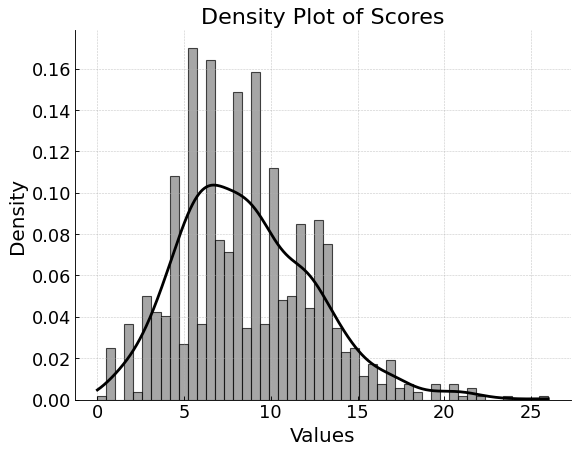

There are 1 ligands with 0 connections (0.1%)
There are 994 ligands with scores greater than 0 (99.9%)
There are 981 ligands with scores greater than 1 (98.6%)
There are 962 ligands with scores greater than 2 (96.7%)
There are 934 ligands with scores greater than 3 (93.9%)
There are 891 ligands with scores greater than 4 (89.5%)
There are 821 ligands with scores greater than 5 (82.5%)
There are 714 ligands with scores greater than 6 (71.8%)
There are 589 ligands with scores greater than 7 (59.2%)
There are 475 ligands with scores greater than 8 (47.7%)
There are 375 ligands with scores greater than 9 (37.7%)
There are 298 ligands with scores greater than 10 (29.9%)
There are 247 ligands with scores greater than 11 (24.8%)
There are 180 ligands with scores greater than 12 (18.1%)
There are 121 ligands with scores greater than 13 (12.2%)
There are 78 ligands with scores greater than 14 (7.8%)
There are 53 ligands with scores greater than 15 (5.3%)
There are 38 ligands with scores greater

In [15]:
plot_ligand_scores(ligand_scores)
# plot_ligand_scores(ligand_scores_unweighted, save_name='good_ligands_iter1_plot_unweighted_connections.png')

In [21]:
parse_and_prepare_diffdock_data(ligand_scores, config=scoring_config, diffdock_samples_path=sampling_config["diffdock_save_path"],
                                threshold=GOOD_LIGANDS_THRESHOLD, lower_percentile=GOOD_LIGANDS_PERCENTILE, scored_db=load_scored_mols(CONFIG_DICT['diffdock_scored_path_list']))

,Unnamed: 0,smiles,cluster_id,score
0,0,Nc1cc(C2CCN(C(=O)Cc3ccccc3)CC2)no1,1,12.5
1,1,Clc1cccc(-n2cnc(-c3ccccc3Nc3ccncc3)n2)c1,1,13.0
2,2,C#CCOCC1CCCN(C(=O)c2cccc(C)c2)C1,1,6.5
3,3,CC(NC(=O)CCn1nnc2ccccc2c1=O)c1cccc(F)c1,1,12.5
4,4,CC1CNc2ccc(NC(=O)c3cnc[nH]3)cc2O1,1,9.0
...,...,...,...,...
995,995,CC1CN(C(=O)c2ccon2)c2cc(F)c(F)cc2NC1=O,1,8.0
996,996,O=C(O)c1ccc(Nc2nc(-c3cccnc3)nc3ccccc23)cc1,1,8.0
997,997,O=C1Cc2cc(OCc3nn(Cc4ccccc4)c4ccccc34)ccc2N1,1,6.5
998,998,Cc1nccs1,1,2.5


# Prepare training dataset for next round of active learning

In [ ]:
# @title Run this cell to ensure paths are correct

PROBABILITY_CALCULATION = "softmax" #@param ["softmax", "linear"]
SOFTMAX_NORMALIZATION_TYPE = "subtract" #@param ["divide", "subtract"]
# @markdown the following variable is only relevant when softmax is selected
SOFTMAX_DIV_FACTOR = 0.25 #@param
N_SAMPLES = 5_000 # @param
if RANDOM_SAMPLING:
    al_suffix = ''
elif PROBABILITY_CALCULATION == 'softmax':
    al_suffix = f"_{PROBABILITY_CALCULATION}"
    if SOFTMAX_NORMALIZATION_TYPE == 'divide':
        al_suffix += f'_divf{SOFTMAX_DIV_FACTOR}'
    else:
        al_suffix += '_sub'
elif PROBABILITY_CALCULATION == 'linear':
    al_suffix = f"_{PROBABILITY_CALCULATION}"
else:
    raise KeyError("Only softmax and linear probabilities are supported")


AL_TRAIN_PATH = f"{AL_PATH}training_sets/{CURRENT_CYCLE_PREFIX}{scoring_config['suffix']}{al_suffix}.csv"
AL_DIFFUSION_PATH = f"{AL_PATH}training_sets/{CURRENT_CYCLE_PREFIX}{scoring_config['suffix']}{al_suffix}_noscore.csv"

print("Will read scored molecules from\n", '/'.join(scoring_config['path_to_scored'].split('/')[6:]))
print("... and good ligands from\n", '/'.join(scoring_config['path_to_good_ligands'].split('/')[6:]))
print("... and clusterings from\n", '/'.join(sampling_config['clusters_save_path'].split('/')[6:]))
print("... and will save the AL training set to\n", '/'.join(AL_TRAIN_PATH.split('/')[6:]))
print("... and will save the no score samplings to\n", '/'.join(AL_DIFFUSION_PATH.split('/')[6:]))

Will read scored molecules from
 5. Scoring/scored_dataframes/model1_baseline_random.csv
... and good ligands from
 5. Scoring/scored_dataframes/model1_baseline_random_threshold11.csv
... and clusterings from
 3. Sampling/clusterings/model1_baseline_random_cluster_to_mols.pkl
... and will save the AL training set to
 6. ActiveLearning/training_sets/model1_baseline_random_threshold11.csv
... and will save the no score samplings to
 6. ActiveLearning/training_sets/model1_baseline_random_threshold11_noscore.csv


Here, we need to map the good data back to the original clusters and create a training set for active learning. THen, perform active learning, generate molecules, and repeat process. Finally, generate 2 million molecules to train BERT

## Definitions

In [ ]:
import numpy as np
np.random.seed(RANDOM_SEED)
import pandas as pd

def compute_cluster_scores():
    good_data = pd.read_csv(scoring_config['path_to_scored'])
    cluster_to_scores = {}
    for index, row in good_data.iterrows():
        cluster_to_scores.setdefault(row['cluster_id'], []).append(row['score'])
    cluster_to_score = {cluster_id: np.mean(scores) for cluster_id, scores in cluster_to_scores.items()}
    return cluster_to_score


In [ ]:
import plotly.graph_objects as go

def plot_probability_distribution(cluster_scores, args_list, bin_size=0.001):
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=[1/100 for _ in range(100)], name='uniform', opacity=0.75, histnorm='probability', xbins=dict(start=-0.1, end=1, size=bin_size)))
    keyToFunc = {"linear": _preprocess_scores_linearly, "softmax": _preprocess_scores_softmax}
    for (func, param_switch, param_value) in args_list:
        suffix, extras = "", {}
        if func == "softmax":
            suffix = f" divf {param_value}" if param_switch else ""
            extras = dict(divide=param_switch, divide_factor=param_value)
        fig.add_trace(go.Histogram(x=list(keyToFunc[func](cluster_scores, **extras).values()), name=f"{func}{suffix}", opacity=0.75, histnorm='probability', xbins=dict(start=-0.1, end=1, size=bin_size)))
    fig.update_layout(barmode='overlay', title="Probabilities of sampling from clusters based on mean scores", xaxis_title="probability", yaxis_title="rel. frequency")
    return fig

def plot_mean_cluster_scores(cluster_scores):
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=list(cluster_scores.values()), opacity=0.75, histnorm='probability'))
    fig.update_layout(barmode='overlay', title="Distribution of cluster scores", xaxis_title="Mean cluster score", yaxis_title="rel. frequency")
    return fig


In [ ]:
import pickle

def _preprocess_scores_linearly(scores, do_negation=False, **kwargs):
    """
        Preprocesses a dictionary of scores by negating and normalizing them.

        The function negates all scores and optionally removes positive scores. If the minimum value among the negated scores
        is less than zero, it shifts all values by subtracting the minimum value and adding 'lowest_score'. The final step is
        to normalize the scores so that their total sum equals to 1.

        Parameters
        ----------
        scores : dict
            A dictionary of scores where the keys are identifiers and the values are their corresponding scores.

        remove_positives : bool, optional (default=False)
            If True, all positive scores are removed after negation.

        lowest_score : int, optional (default=1)
            This value is added to all scores if the minimum score is less than zero.

        Returns
        -------
        normalized : dict
            The normalized dictionary of scores.

    """
    sign = -1 if do_negation else 1
    negated = {k: sign*v for k, v in scores.items()}
    total = sum(negated.values())
    normalized = {k: v / total for k, v in negated.items()}
    return normalized

def _preprocess_scores_softmax(scores, do_negation=False, divide=True, divide_factor=None):
    sign = -1 if do_negation else 1
    negated = {k: sign*v for k, v in scores.items()}
    max_value = max(negated.values())
    if divide:
        assert divide_factor is not None, 'You have to specify a value p in (0, 1). Softmax is computed as e^[x/(p*max)]'
        exponentiate = {k: np.exp(v / (divide_factor*max_value)) for k, v in negated.items()}
    else:
        exponentiate = {k: np.exp(v - max_value) for k, v in negated.items()}
    total = sum(exponentiate.values())
    softmax = {k: v / total for k, v in exponentiate.items()}
    return softmax

def balance_cluster_to_n(cluster_to_n, cluster_to_len):
    """
        Balances the target number of samples for each cluster to ensure it doesn't exceed the actual size of the cluster.

        The function first calculates the surplus (i.e., the excess of the target number over the actual size) for each cluster.
        Then, it distributes the total surplus proportionally among the clusters that have a deficit (i.e., the target number is less than the actual size).
        If after this distribution, there's still a deficit (i.e., the sum of target numbers is less than the sum of actual sizes), the function
        increases the target number of the largest clusters one by one until the sum of target numbers equals to the sum of actual sizes.

        Parameters
        ----------
        cluster_to_n : dict
            A dictionary mapping cluster identifiers to their target number of samples.

        cluster_to_len : dict
            A dictionary mapping cluster identifiers to the actual size of each cluster.

        Returns
        -------
        balanced : dict
            A dictionary mapping cluster identifiers to their balanced target number of samples.

        Raises
        ------
        AssertionError
            If the sum of target numbers before and after balancing don't match.

    """

    surplus = {key: cluster_to_n[key] - cluster_to_len[key] for key in cluster_to_n if cluster_to_n[key] > cluster_to_len[key]}
    balanced = {k:v for k, v in cluster_to_n.items()}
    n_to_cluster = {v: k for k, v in cluster_to_n.items()}

    for key in surplus:
        balanced[key] = cluster_to_len[key]

    total_surplus = sum(surplus.values())
    initial_n_sum = sum(n for key, n in cluster_to_n.items() if key not in surplus)

    for key in balanced:
        if key in surplus: continue
        surplus_to_add = total_surplus * cluster_to_n[key] / initial_n_sum
        new_n = int(cluster_to_n[key] + surplus_to_add)
        balanced[key] = min(new_n, cluster_to_len[key])

    deficit = sum(cluster_to_n.values()) - sum(balanced.values())
    while deficit > 0:
        for initial_n in sorted(n_to_cluster, reverse=True):
            if deficit == 0:
                break
            if (cluster:=n_to_cluster[initial_n]) in surplus: continue
            if balanced[cluster] < cluster_to_len[cluster]:
                balanced[cluster] += 1
                deficit -= 1

    assert sum(cluster_to_n.values()) == sum(balanced.values()), f"Before balancing had {sum(cluster_to_n.values())}, post balancing = {sum(balanced.values())}"
    return balanced

def sample_clusters_for_active_learning(cluster_to_scores, n_samples, config, probability_type='softmax', divide=True, divide_factor=None):
    """
        Sample molecules from clusters for active learning purposes, considering previously docked molecules and balancing the sampling among clusters.

        This function uses either softmax or uniform probabilities to determine how many molecules to sample from each cluster. The function then samples
        the required number of new molecules (i.e., those not present in docked_mols) from each cluster. The sampling is balanced to ensure the target number
        doesn't exceed the actual size of the cluster.

        Parameters
        ----------
        cluster_to_scores : dict
            A dictionary mapping cluster identifiers to their scores.

        n_samples : int
            The total number of molecules to sample.

        path_to_clusters : str
            The path to a pickle file storing a dictionary that maps each cluster to a list of molecules.

        probability_type : str, optional (default='softmax')
            The type of probability distribution used to determine the number of samples per cluster.
            Options are 'softmax' and 'uniform'.

        remove_positives : bool, optional (default=False)
            Only used when probability_type is 'uniform'. If True, positive scores are removed after negation.

        lowest_score : int, optional (default=1)
            Only used when probability_type is 'uniform'. This value is added to all scores if the minimum score is less than zero.

        Returns
        -------
        training : list
            A list of randomly sampled molecules for active learning.

        Raises
        ------
        KeyError
            If an unsupported probability_type is provided.
        AssertionError
            If the number of sampled molecules doesn't equal to n_samples.

    """
    if probability_type == 'softmax':
        probability_function = lambda x: _preprocess_scores_softmax(x, divide=divide, divide_factor=divide_factor)
    elif probability_type == 'linear':
        probability_function = lambda x: _preprocess_scores_linearly(x)
    elif probability_type == 'no_score':
        probability_function = lambda x: x
    else:
        raise KeyError("Only uniform and softmax probabilities are supported")
    cluster_to_mols = pickle.load(open(config['clusters_save_path'], 'rb'))
    cluster_to_samples = pickle.load(open(config['samples_save_path'], 'rb'))
    docked_mols = {smile for smiles in cluster_to_samples.values() for smile in smiles}
    cluster_to_new_mols = {k: [smile for smile in set(v) if smile not in docked_mols] for k, v in cluster_to_mols.items()}

    probabilities = probability_function(cluster_to_scores)
    # print(f"Probabilities\n", probabilities)
    cluster_to_n = {k: int(v * n_samples) for k, v in probabilities.items()}
    max_cluster_id, max_prob = None, 0
    for cluster, prob in probabilities.items():
        if prob > max_prob:
            max_cluster_id, max_prob = cluster, prob
    cluster_to_n[max_cluster_id] += n_samples - sum(cluster_to_n.values())

    cluster_to_len = {k: len(v) for k, v in cluster_to_new_mols.items()}
    balanced = balance_cluster_to_n(cluster_to_n, cluster_to_len)

    training = []
    np.random.seed(RANDOM_SEED)
    for i, (cluster, n) in enumerate(balanced.items()):
        training.extend(np.random.choice(cluster_to_new_mols[cluster], n, replace=False))
    assert len(training) == n_samples, f"{len(training)=} != {n_samples=}"
    return training


In [ ]:
def combine_sampled_and_good_ligands(sampled, good_ligands, good_ligand_multiplier:int, save_path):
    assert isinstance(good_ligand_multiplier, int), "A multiplier should be an integer"
    keyToData = {}
    if sampled is not None:
        print(f"Sampled {len(sampled)} molecules, of which {len(set(sampled))} are unique")
        for mol in sampled:
            keyToData.setdefault('smiles', []).append(mol)
    for mol in good_ligands:
        for _ in range(good_ligand_multiplier):
            keyToData.setdefault('smiles', []).append(mol)
    combined = pd.DataFrame(keyToData)
    print("Combined dataframe has shape", combined.shape)
    combined.to_csv(save_path)
    return combined

## Runs

In [ ]:
cluster_to_score = compute_cluster_scores()
plot_mean_cluster_scores(cluster_to_score).show()

In [ ]:
plot_probability_distribution(cluster_to_score, [
    ("linear", None, None), ("softmax", False, np.nan), ("softmax", True, 1), ("softmax", True, 0.5), ("softmax", True, 0.25)
], bin_size=0.001)

In [ ]:
good_ligands = pd.read_csv(scoring_config['path_to_good_ligands'])
print(f"There are {len(good_ligands)} good ligands")
gl_mult = int(np.ceil(N_SAMPLES/len(good_ligands)))

training_sampled = sample_clusters_for_active_learning(cluster_to_score, n_samples=N_SAMPLES, config=sampling_config, probability_type=PROBABILITY_CALCULATION, divide=True if SOFTMAX_NORMALIZATION_TYPE == 'divide' else False, divide_factor=SOFTMAX_DIV_FACTOR)
df1 = combine_sampled_and_good_ligands(training_sampled, good_ligands['smiles'].values, good_ligand_multiplier=gl_mult,
                                 save_path=AL_TRAIN_PATH)

diffusion_sampled = sample_clusters_for_active_learning({cluster_id: 1/100 for cluster_id in cluster_to_score.keys()}, n_samples=N_SAMPLES, config=sampling_config, probability_type='no_score', divide=True if SOFTMAX_NORMALIZATION_TYPE == 'divide' else False, divide_factor=SOFTMAX_DIV_FACTOR)
df2 = combine_sampled_and_good_ligands(diffusion_sampled, good_ligands['smiles'].values, good_ligand_multiplier=gl_mult,
                                 save_path=AL_DIFFUSION_PATH)

In [ ]:
good_ligands = pd.read_csv(scoring_config['path_to_good_ligands'])
print(f"There are {len(good_ligands)} good ligands")
gl_mult = int(np.ceil(N_SAMPLES/len(good_ligands)))

df1 = combine_sampled_and_good_ligands(None, good_ligands['smiles'].values, good_ligand_multiplier=gl_mult,
                                 save_path=AL_TRAIN_PATH)

There are 243 good ligands
Combined dataframe has shape (5103, 1)


# Active Learning

In [ ]:
# @title Run this cell to ensure proper variables are set
assert MODE == 'Active Learning', "Please go to the beginning of the notebook and set the MODE to Active Learning"
# @markdown if true, weights will be loaded from 1. Pretraining/model_weights
# @markdown otherwise from 6. Active Learning/model_weights
LOAD_FROM_BASELINE = True #@param {type:"boolean"}
LOAD_CKPT_FNAME = "GPT_pretrain_07_14_23:39_1end_ignore_moses+bindingdb.pt" #@param ["GPT_pretrain_07_14_23:39_1end_ignore_moses+bindingdb.pt", "model1_softsub_al1.pt"]
if LOAD_FROM_BASELINE:
    CONFIG_DICT['load_ckpt_path'] = f"{PRETRAINING_PATH}model_weights/{LOAD_CKPT_FNAME}"
else:
    CONFIG_DICT['load_ckpt_path'] = f"{AL_PATH}model_weights/{LOAD_CKPT_FNAME}"

CONFIG_DICT["desc_path"] = f"{AL_PATH}dataset_descriptors/{AL_TRAIN_PATH.split('/')[-1][:-4]}.yaml"
sampling_config['path_to_predicted'] = '/content/drive/MyDrive/Generative_ML/current_data/2. Generation/smiles/model1_baseline_temp1.0_processed.csv'
sampling_config['path_to_completions'] = '/content/drive/MyDrive/Generative_ML/current_data/2. Generation/smiles/model1_baseline_temp1.0_completions.csv'
CONFIG_DICT['al_path'] = AL_TRAIN_PATH.split('.csv')[0]+'_translated.csv'

print("Generated molecules from previous round will be read from\n", '/'.join(sampling_config['path_to_predicted'].split('/')[6:]))
print("... active learning will be performed on\n", '/'.join(CONFIG_DICT['al_path'].split('/')[6:]))
print('... model weights will be LOADED from\n', '/'.join(CONFIG_DICT['load_ckpt_path'].split('/')[6:]))
print('... model weights will be SAVED to\n', '/'.join(CONFIG_DICT['save_ckpt_path'].split('/')[6:]))
print('... dataset descriptors will be saved to\n', '/'.join(CONFIG_DICT['desc_path'].split('/')[6:]))

Generated molecules from previous round will be read from
 2. Generation/smiles/model1_baseline_temp1.0_processed.csv
... active learning will be performed on
 6. ActiveLearning/training_sets/model1_baseline_random_threshold11_translated.csv
... model weights will be LOADED from
 1. Pretraining/model_weights/GPT_pretrain_07_14_23:39_1end_ignore_moses+bindingdb.pt
... model weights will be SAVED to
 6. ActiveLearning/model_weights/model1_random_al1.pt
... dataset descriptors will be saved to
 6. ActiveLearning/dataset_descriptors/model1_baseline_random_threshold11.yaml



### Translation Definition

In [ ]:
from tqdm import tqdm
from rdkit import Chem

def get_mol(smile_string):
    mol = Chem.MolFromSmiles(smile_string)
    if mol is None:
        return None
    try:
        Chem.SanitizeMol(mol)
    except ValueError:
        return None
    return mol

def fill_translation_table():
    smile_df = pd.read_csv(sampling_config['path_to_completions'])
    rdkit_to_predicted = {}
    pbar = tqdm(smile_df['smiles'], total=len(smile_df))
    for completion in pbar:
        if '~' not in completion: continue
        mol_string = completion[1:completion.index('~')]
        mol = get_mol(mol_string)
        if mol is None: continue
        canonic_smile = Chem.MolToSmiles(mol)
        rdkit_to_predicted[canonic_smile] = mol_string
    return rdkit_to_predicted

def translate_dataset_for_al():
    rdkit_to_predicted = fill_translation_table()
    sampled = pd.read_csv(AL_TRAIN_PATH)
    translated = []
    for mol in sampled['smiles'].values:
        mol = rdkit_to_predicted[mol]
        translated.append(mol)
    pd.DataFrame({"smiles": translated}).to_csv(AL_TRAIN_PATH.split('.csv')[0]+'_translated.csv')


### Run

In [ ]:
translate_dataset_for_al()

In [ ]:
def load_pretraining_vocab():
    import yaml
    with open(f"{PRETRAINING_PATH}dataset_descriptors/moses_and_binding_no_rare_tokens.yaml", 'r') as f:
        data = yaml.load(f, Loader=yaml.FullLoader)
    return set(data['stoi'].keys())

In [ ]:
al_train_dataset = load_data(CONFIG_DICT, mode='al', forced_block_size=131, forced_vocab=load_pretraining_vocab())[0]
print(al_train_dataset.vocab_size, al_train_dataset.block_size)

Loading AL dataset from 6. ActiveLearning/training_sets/model1_baseline_random_threshold11_translated.csv
45 131


In [ ]:
model, trainer, wandb = train_GPT(
                train_dataset = al_train_dataset,
                config_dict = CONFIG_DICT,
                load_ckpt=True
        )
wandb.finish()
#GK wandb API Key: c99c9a01523f93287716691fa3360b1f4566e115
#RB wandb API Key: 4d3d628c6b5a4b3554c7a89ea50df8a4a6be0f85
#AM wandb API key: 5be14d5930441de4707f6a58e4f7c2e229dab1d1

env: WANDB_EXECUTABLE=python3


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


epoch=0


epoch 1 iter 9: train loss 0.45499. lr 2.926585e-05: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


epoch=1


epoch 2 iter 9: train loss 0.42621. lr 2.713525e-05: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


epoch=2


epoch 3 iter 9: train loss 0.39971. lr 2.381678e-05: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


epoch=3


epoch 4 iter 9: train loss 0.39309. lr 1.963525e-05: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


epoch=4


epoch 5 iter 9: train loss 0.36222. lr 1.500000e-05: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


epoch=5


epoch 6 iter 9: train loss 0.36093. lr 1.036475e-05: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


epoch=6


epoch 7 iter 9: train loss 0.35033. lr 6.183221e-06: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


epoch=7


epoch 8 iter 9: train loss 0.34563. lr 3.000000e-06: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


epoch=8


epoch 9 iter 9: train loss 0.34754. lr 3.000000e-06: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


epoch=9


epoch 10 iter 9: train loss 0.33617. lr 3.000000e-06: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


epoch,▁▂▃▃▄▅▆▆▇█
epoch_train_loss,█▆▅▄▃▂▂▁▁▁
learning_rate,███████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
step_train_loss,██▇▇▇▆▆▆▅▅▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁
train_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,10
epoch_train_loss,0.34342
learning_rate,0.0
step_train_loss,0.33617
train_step,99


#BERT

##Set up notebook

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# install necessary packages
!pip install rdkit
!pip install pandas==1.5.3
!pip install molsets
!pip install wandb

# clone Sophia optimizer GitHub repository
!git clone https://github.com/Liuhong99/Sophia.git

# import necessary packages
import numpy as np
import h5py
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, pairwise_distances
import os
from scipy import stats
import matplotlib.pyplot as plt
import pkg_resources
pkg_resources.require("pandas==1.5.3")
import pandas as pd
import re
import math
import random
import logging
import wandb
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
import torch.optim as optim
from torch.cuda.amp import GradScaler
from rdkit import Chem
from rdkit.Chem import QED, Crippen
from rdkit.Contrib.SA_Score import sascorer
from rdkit.Chem.rdMolDescriptors import CalcTPSA
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
import moses
from moses.utils import get_mol
from Sophia.sophia import SophiaG
import yaml

# set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

##Utils & Dataset

In [ ]:
@torch.no_grad()
def sample(model, x, steps, temperature=1.0, prop=None, scaffold=None):
    block_size = model.get_block_size() # define size of context window used for input conditioning
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # limit conditioning input to the most recent block_size elements
        logits, _= model(x_cond, prop = prop, scaffold = scaffold) # give input to model and get logits (unnormalized scores or probabilities)
        logits = logits[:, -1, :] / temperature # extract the logits for the next token in the sequence
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, 1)
        x = torch.cat((x, ix), dim=1) # concatenate the chosen token index with the existing sequence
    return x



@torch.no_grad()
def fill_mask(model, x, temperature=1.0, prop=None, scaffold=None):
    block_size = model.get_block_size()  # Get model's maximum context length
    model.eval()

    # Check if mask token is present
    mask_index = model.config.mask_index  # Assuming 'mask_index' is available in your model's config
    while mask_index in x[0]:  # If mask token is present
        # Find all mask positions
        mask_positions = (x[0] == mask_index).nonzero(as_tuple=True)

        for pos in mask_positions:  # Iterate over each mask position
            # Limit conditioning input to the most recent block_size elements
            x_cond = x if x.size(1) <= block_size else x[:, -block_size:]
            # Get token probabilities
            logits, _ = model(x_cond, prop=prop, scaffold=scaffold)

            # Extract the logits for the masked token position, apply temperature and softmax to get probabilities
            logits = logits[0, pos, :] / temperature
            probs = F.softmax(logits, dim=-1)
            ix = torch.multinomial(probs, 1)  # Sample token from probability distribution

            x[0, pos] = ix  # Replace mask token with sampled token

    return x  # Return unmasked tensor

def check_novelty(gen_smiles, train_smiles):
    if len(gen_smiles) == 0:
        novel_ratio = 0
    else:
        duplicates = [1 for mol in gen_smiles if mol in train_smiles]
        novel = len(gen_smiles) - sum(duplicates)
        novel_ratio = novel*100/len(gen_smiles)
    return novel_ratio

def canonic_smiles(smiles_or_mol):
    mol = get_mol(smiles_or_mol)
    if mol is None:
        return None
    return Chem.MolToSmiles(mol)

class SMILESDataset(Dataset):

    def __init__(self, data=None, content=None, block_size=None, prop=None, scaffold=None, scaffold_maxlen=None, len_data=None, mask_prob=0.15):
        if content is None:
            self.desc_only = True
            return
        self.desc_only = False
        self.chars = sorted(list(set(content)))
        data_size, vocab_size = len(content), len(self.chars)
        self.vocab_size = vocab_size

        self.stoi = {ch:i for i,ch in enumerate(self.chars)}
        self.itos = {i:ch for i,ch in enumerate(self.chars)}
        self.max_len = block_size
        self.data = data
        self.prop = prop
        self.sca = scaffold
        self.scaf_max_len = scaffold_maxlen
        self.len_data = len_data
        self.mask_prob = mask_prob

        # add X token to vocabulary
        self.stoi['X'] = len(self.stoi)
        self.itos[len(self.itos)] = 'X'
        self.vocab_size = len(self.stoi)

    def export_desc_attributes(self, export_path):
        attr_dict = {
            "desc_only": self.desc_only,
            "vocab_size": self.vocab_size,
            "max_len": self.max_len,
            "stoi": self.stoi,
            "itos": self.itos,
            "scaf_max_len": self.scaf_max_len,
            "len_data": self.len_data
        }
        with open(export_path, 'w') as f:
            yaml.dump(attr_dict, f)

    def load_desc_attributes(self, load_path):
        with open(load_path, 'r') as f:
            attr_dict = yaml.load(f, Loader=yaml.SafeLoader)
        self.__dict__.update(attr_dict)

    def __len__(self):
        assert not self.desc_only, "Dataset is not initialized"
        return len(self.data)

    def __getitem__(self, idx):
        assert not self.desc_only, "Dataset is not initialized"
        smiles, prop, scaffold = self.data[idx].strip(), self.prop[idx], self.sca[idx]
        if scaffold:
          scaffold=scaffold.strip()
        pattern =  "(\[[^\]]+]|<|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9]|X)"
        regex = re.compile(pattern)

        #tokenize input string
        tokens_arr=regex.findall(smiles)

        #Save ground truth encodings before token masking
        smiles_true = smiles+str('<')*(self.max_len - len(tokens_arr))
        if len(tokens_arr) > self.max_len:
            smiles_true = smiles[:self.max_len]
        dix_true=[self.stoi[s] for s in regex.findall(smiles_true)]



        # randomly replace tokens
        mask_idx = [] #True indicates that the corresponding position will be ignored for computing loss
        for s in range(len(tokens_arr)):
          if random.random() < .15:
            mask_idx.append(False)
            num = random.random()
            if num >= .2: # 80%
                tokens_arr[s]='X'
            elif num >= 0.1: # 10%
                tokens_arr[s] = self.chars[int(random.random()*len(self.chars))]
          else:
            mask_idx.append(True)

        #pad the mask appropriately
        while len(mask_idx)<self.max_len:
            mask_idx.append(True)

        assert len(mask_idx)==self.max_len
        smiles=''.join(tokens_arr)

        smiles += str('<')*(self.max_len - len(regex.findall(smiles)))
        if len(regex.findall(smiles)) > self.max_len:
            smiles = smiles[:self.max_len]

        assert len(''.join(regex.findall(smiles)))==len(smiles)
        smiles=regex.findall(smiles)


        dix =  [self.stoi[s] for s in smiles]
        if scaffold:
          scaffold += str('<')*(self.scaf_max_len - len(regex.findall(scaffold)))
          if len(regex.findall(scaffold)) > self.scaf_max_len:
              scaffold = scaffold[:self.scaf_max_len]
          scaffold=regex.findall(scaffold)
          sca_dix = [self.stoi[s] for s in scaffold]
          sca_tensor = torch.tensor(sca_dix, dtype=torch.long)
        else:
          sca_tensor=torch.tensor(scaffold,dtype=torch.bool)
        x = torch.tensor(dix, dtype=torch.long)
        y = torch.tensor(dix_true, dtype=torch.long)
        prop = torch.tensor([prop], dtype=torch.float)
        return x, y, prop, sca_tensor, torch.tensor(mask_idx)

##Model

In [ ]:
class GPTConfig:
    def __init__(self, vocab_size=None, block_size=None, mask_index=None, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.mask_index = mask_index
        for k,v in kwargs.items():
            setattr(self, k, v)

    def export_attributes(self, export_path):
        with open(export_path, 'w') as f:
            yaml.dump(vars(self), f)

    def load_attributes(self, load_path):
        with open(load_path, 'r') as f:
            config_dict = yaml.load(f, Loader=yaml.SafeLoader)
        self.__dict__.update(config_dict)

class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embed % config.n_head == 0
        self.config = config

        self.query = nn.Linear(config.n_embed, config.n_embed, bias=config.att_bias)
        self.key = nn.Linear(config.n_embed, config.n_embed, bias=config.att_bias)
        self.value = nn.Linear(config.n_embed, config.n_embed, bias=config.att_bias)

        self.attn_drop = nn.Dropout(config.att_drop_rate)
        self.resid_drop = nn.Dropout(config.att_drop_rate)

        self.proj = nn.Linear(config.n_embed, config.n_embed)
        self.n_head = config.n_head

        num = int(bool(config.num_props)) + int(config.scaffold_maxlen)
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size + num, config.block_size + num))
                                .view(1, 1, config.block_size + num, config.block_size + num))

    def forward(self, x, layer_past=None):
        B, T, C = x.size()
        # apply attention functions to get tensors with dimensions (B, n_head, T, head_size)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head)
        k = self.key(x).view(B, T, self.n_head, C // self.n_head)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head)
        if self.config.do_flash:
            q = q.transpose(1, 2)
            k = k.transpose(1, 2)
            v = v.transpose(1, 2)
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, dropout_p=self.config.att_drop_rate if self.training else 0, is_causal=self.config.is_causal)
            y = y.transpose(1, 2)
        else:
            # (B h T s) @ (B h s T) -> (B h T T)
            att = torch.einsum('bths,bihs->bhti', q, k) / math.sqrt(k.size(-1))
            att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            # (B h T T) @ (B h T s) -> (B h T s)
            y = torch.einsum('bhtq,bqhs->bths', att, v)
            self.att_weights = att
        self.attended = y
        y = y.contiguous().view(B, T, C)
        y = self.resid_drop(self.proj(y))
        self.out = y
        return y

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embed)
        self.ln2 = nn.LayerNorm(config.n_embed)
        self.attn = SelfAttention(config)
        self.mlp = nn.Sequential(nn.Linear(config.n_embed, config.ff_mult*config.n_embed), nn.GELU() if config.doGELU else nn.ReLU(),
            nn.Linear(config.ff_mult*config.n_embed, config.n_embed), nn.Dropout(config.att_drop_rate))

    def forward(self, x):
        y = self.attn(self.ln1(x))
        x = x + y # perform a residual connection by summing input and attention output
        x = x + self.mlp(self.ln2(x)) # apply layer normalization and then MLP, create a residual connection with input
        return x

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embed)
        self.type_emb = nn.Embedding(2, config.n_embed)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embed))
        # if conditioning on at least 1 property:
        if config.num_props:
            # initialize property linear layer, map property vector to embedding dimension
            self.prop_nn = nn.Linear(config.num_props, config.n_embed)

        self.drop = nn.Dropout(config.gpt_drop_rate)
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])

        self.ln_f = nn.LayerNorm(config.n_embed)
        self.head = nn.Linear(config.n_embed, config.vocab_size, bias=config.gpt_bias)
        self.block_size = config.block_size # define the context size
        self.apply(self._init_weights) # initialize weights and apply to all relevant modules in the model

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def configure_optimizers(self, train_config):
        decay, no_decay = set(), set()
        no_decay = set()

        whitelist_weight_modules = (torch.nn.Linear)
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        # for named module of the model:
        for mn, m in self.named_modules():
            # for named parameter of each module:
            for pn, p in m.named_parameters():
                # construct full parameter name by concatenating module name and parameter name, separated by a dot
                fpn = '%s.%s' % (mn, pn) if mn else pn
                if pn.endswith('bias') or ('bias' in pn):
                    no_decay.add(fpn)
                elif (pn.endswith('weight') or ('weight' in pn)) and isinstance(m, whitelist_weight_modules):
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    no_decay.add(fpn)
        no_decay.add('pos_emb')
        param_dict = {pn:p for pn, p in self.named_parameters()}
        assert len(decay & no_decay) == 0
        # assert that all parameters from both sets have been correctly separated
        assert len(param_dict.keys() - (decay | no_decay)) == 0
        optim_groups = [{"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
                        {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0}]
        optimizer = SophiaG(optim_groups, lr=train_config.learning_rate, betas=train_config.betas, rho=train_config.rho, weight_decay=train_config.weight_decay)
        return optimizer

    def forward(self, idx, targets=None, prop=None, scaffold=None):
        b, t = idx.size()
        assert t <= self.block_size
        if self.config.num_props:
            assert prop.size(-1) == self.config.num_props, f"number of properties {prop.size(-1)=} doesn't match the expected size {self.config.num_props=}"
        token_embeddings = self.tok_emb(idx)
        position_embeddings = self.pos_emb[:, :t, :]
        type_embeddings = self.type_emb(torch.ones((b,t), dtype=torch.long, device=idx.device))
        x = self.drop(token_embeddings + position_embeddings + type_embeddings)
        # Condition on properties
        if self.config.num_props:
            type_embd = self.type_emb(torch.zeros((b, 1), dtype=torch.long, device=idx.device))
            if prop.ndim == 2:
                p = self.prop_nn(prop.unsqueeze(1))
            else:
                p = self.prop_nn(prop)
            p += type_embd
            x = torch.cat([p, x], 1)
        # Condition on scaffold
        if self.config.scaffold:
            type_embd = self.type_emb(torch.zeros((b, 1), dtype = torch.long, device = idx.device))
            scaffold_embeds = self.tok_emb(scaffold)
            scaffold_embeds += type_embd
            x = torch.cat([scaffold_embeds, x], 1)

        # Transformer blocks
        for layer in self.blocks:
            x = layer(x)
        x = self.ln_f(x)
        logits = self.head(x)

        if self.config.num_props and self.config.scaffold:
            num = int(bool(self.config.num_props)) + int(self.config.scaffold_maxlen)
        elif self.config.num_props:
            num = int(bool(self.config.num_props))
        elif self.config.scaffold:
            num = int(self.config.scaffold_maxlen)
        else:
            num = 0
        # Slice the logits tensor along the second dimension to exclude the first num elements
        logits = logits[:, num:, :]

        return logits

##Training

In [ ]:
class TrainerConfig:
    epochs = 10
    batch_size = 64
    learning_rate = 3e-4
    betas = (0.965, 0.99) #(0.9, 0.95)
    rho = 0.04 # For SophiaG
    weight_decay = 0.1

    lr_decay = False
    warmup_tokens = 375e6 # number of warm-up tokens for learning rate decay
    final_tokens = 260e9 # number of tokens at which the learning rate decays to 10% of the original
    num_workers = 0 # number of worker processes to use for loading data

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

def loss_function(logits, y, mask_idx):
    loss=nn.CrossEntropyLoss(ignore_index=-1)
    y[mask_idx]=-1
    return loss(logits.view(-1,logits.size(-1)),y.view(-1))

class Trainer:

    def __init__(self, model, train_dataset, test_dataset, config, stoi, itos):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = config
        self.stoi = stoi
        self.itos = itos
        self.model = self.model.to(config.device)

    def train(self, wandb):
        model, config = self.model, self.config
        optimizer = model.configure_optimizers(config)
        scaler = GradScaler() # define variable used for gradient scaling in mixed-precision training
        self.tokens = 0 # initialize a counter used for learning rate decay

        def run_epoch(split):
            is_train = split == 'train'
            model.train(is_train)
            data = self.train_dataset if is_train else self.test_dataset
            loader = DataLoader(data, shuffle=True, pin_memory=True, batch_size=config.batch_size, num_workers=config.num_workers)
            losses = []
            pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
            # for batch index, batch in progress bar:
            for it, (x, y, p, scaffold, mask_idx) in pbar:
                # move the input data tensor, target data tensor, property tensor, and scaffold tensor to GPU
                x, y, p, scaffold , mask_idx = x.to(config.device), y.to(config.device), p.to(config.device), scaffold.to(config.device), mask_idx.to(config.device)
                # allow model to use lower-precision computations for improved memory usage
                if config.device == 'cuda':
                    with torch.cuda.amp.autocast():
                        with torch.set_grad_enabled(is_train):
                            logits= model(x, y, p, scaffold)
                            loss = loss_function(logits, y, mask_idx)
                            loss = loss.mean()
                            losses.append(loss.item())
                else:
                    with torch.cpu.amp.autocast():
                        with torch.set_grad_enabled(is_train):
                            logits = model(x, y, p, scaffold)
                            loss = loss_function(x, y, mask_idx)
                            loss = loss.mean()
                            losses.append(loss.item())

                if is_train:
                    model.zero_grad()
                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer) # unscale the gradients of the optimizer's parameters to their original values
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip gradients of model parameters to prevent them from exploding, setting maximum gradient norm to be 1.0
                    scaler.step(optimizer) # update the optimizer's parameters based on calculated gradients
                    scaler.update() # update the scale factor of the gradient scaler
                    if config.lr_decay:
                        self.tokens += (y >= 0).sum() # increment the number of processed tokens by the count of valid tokens (not padding or special tokens)
                        if self.tokens < config.warmup_tokens:
                            lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens)) # perform a linear warm-up
                        else:
                            # calculate the progress of training in terms of the number of tokens processed
                            progress = float(self.tokens - config.warmup_tokens) / float(max(1, config.final_tokens - config.warmup_tokens))
                            # calculate the scaling factor for the learning rate (between 0.1 and 1.0)
                            # to gradually reduce learning rate as training progresses
                            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                        lr = config.learning_rate * lr_mult # multiply the base learning rate by the scaling factor to obtain the updated learning rate
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                    else:
                        lr = config.learning_rate
                    # log training progress using Weights & Biases
                    if wandb is not None:
                        wandb.log({'step_train_loss': loss, 'train_step': it + epoch*len(loader), 'learning_rate': lr})
                    # update the description of the progress bar with epoch, iteration, and training loss
                    pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. lr {lr:e}")
            return float(np.mean(losses))


        # initialize best loss as infinity
        best_loss = float('inf')
        for epoch in range(config.epochs):
            print(f'{epoch=}')
            train_loss = run_epoch('train')
            if self.test_dataset is not None:
                test_loss = run_epoch('test')
            if wandb is not None:
                wandb.log({'epoch_valid_loss': test_loss, 'epoch_train_loss': train_loss, 'epoch': epoch + 1})
            good_model = self.test_dataset is None or test_loss < best_loss
            if good_model:
                best_loss = test_loss
                torch.save(self.model.state_dict(), self.config.ckpt_path)

In [ ]:
def load_data(train_config_dict):
    if (cut:=train_config_dict["slice_data"]):
        train_data = pd.read_csv(train_config_dict["train_path"])[:cut]
        val_data = pd.read_csv(train_config_dict["val_path"])[:cut]
    else:
        train_data = pd.read_csv(train_config_dict["train_path"])
        val_data = pd.read_csv(train_config_dict["val_path"])

    smiles = train_data['smiles']
    vsmiles = val_data['smiles']

    prop = train_data[train_config_dict["props"]].values.tolist()
    vprop = val_data[train_config_dict["props"]].values.tolist()

    scaffold = train_data['scaffold_smiles']
    vscaffold = val_data['scaffold_smiles']

    # define a regular expression that matches molecular tokens in SMILES strings
    pattern = "(\[[^\]]+]|<|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9]|X)"
    # compile pattern into a regular expression object that can be used for matching operations
    regex = re.compile(pattern)

    context = {'<'}

    max_len, scaffold_max_len = 0, 0
    for iterator in (smiles.values, vsmiles.values):
        for i in iterator:
            chars = regex.findall(i.strip())
            max_len = max(max_len, len(chars))
            for char in chars:
                context.add(char)
    for iterator in (scaffold.values, vscaffold.values):
        for i in iterator:
            chars = regex.findall(i.strip())
            scaffold_max_len = max(scaffold_max_len, len(chars))
            for char in chars:
                context.add(char)
    print(max_len)
    context = sorted(list(context))

    smiles = [i + str('<')*(max_len - len(regex.findall(i.strip()))) for i in smiles]
    vsmiles = [i + str('<')*(max_len - len(regex.findall(i.strip()))) for i in vsmiles]
    scaffold = [i + str('<')*(scaffold_max_len - len(regex.findall(i.strip()))) for i in scaffold]
    vscaffold = [i + str('<')*(scaffold_max_len - len(regex.findall(i.strip()))) for i in vscaffold]

    # if not conditioning on scaffolds: define 'scaffold' as a list of length SMILES string filled with 'False' values
    scaffold=[False]*len(smiles) if not train_config_dict["use_scaf"] else scaffold
    train_dataset = SMILESDataset(smiles, context, max_len, prop=prop, scaffold=scaffold, scaffold_maxlen=scaffold_max_len, len_data=len(train_data), mask_prob=0.15)
    valid_dataset = SMILESDataset(vsmiles, context, max_len, prop=vprop, scaffold=vscaffold, scaffold_maxlen=scaffold_max_len, len_data=len(val_data), mask_prob=0.15)
    train_dataset.export_desc_attributes(train_config_dict["desc_path"])
    return train_dataset, valid_dataset

In [ ]:
def pretrain_BERT(train_dataset, valid_dataset, model_config_dict, train_config_dict):
  """
  OUTPUTS:
  1) checkpoint of trained model parameters
  2) Weights & Biases logged run
  """

  mask_index = train_dataset.stoi['X']
  mconf = GPTConfig(train_dataset.vocab_size, train_dataset.max_len, mask_index=mask_index, num_props=len(train_config_dict["props"]), scaffold=train_config_dict["use_scaf"], scaffold_maxlen=train_dataset.scaf_max_len, **model_config_dict)
  model = GPT(mconf).to(model_config_dict["device"])

  if train_config_dict['load_cpt'] != None:
    model.load_state_dict(torch.load(train_config_dict['load_cpt']))
  torch.compile(model)

  tconf = TrainerConfig(warmup_tokens=0.1*train_dataset.len_data*train_dataset.max_len, final_tokens=train_config_dict["epochs"]*train_dataset.len_data*train_dataset.max_len, block_size=train_dataset.max_len, **train_config_dict)
  trainer = Trainer(model, train_dataset, valid_dataset, tconf, train_dataset.stoi, train_dataset.itos)

  %env WANDB_EXECUTABLE=python3
  wandb.init(project="mol_transformer", name=train_config_dict["wandb_runname"])
  trainer.train(wandb=wandb)
  return model, tconf

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
BASE = '/content/drive/MyDrive/Generative_ML/'

model_config_dict = {
    "device": DEVICE,
    "att_bias": False,
    "gpt_bias": True,
    "att_drop_rate": 0.1,
    "gpt_drop_rate": 0.1,
    "n_layer": 8,
    "n_head": 8,
    "n_embed": 256,
    "ff_mult": 4, # multiplier for FF inside multihead,
    "doGELU": True, # else ReLU
    "attention_times": [],
    "do_flash": True,
    "is_causal": False
}

train_config_dict = {
    "desc_path": BASE + 'checkpoints/descriptors_10k.yaml',
    "train_path": BASE + 'data/MOSES_processed_train.csv',
    "val_path": BASE + 'data/MOSES_processed_val.csv',
    "slice_data": False,
    "ckpt_path": BASE + 'checkpoints/7-03_all_mask.pt',
    "wandb_runname": "7_03_all_mask",
    "use_scaf": False,
    "props": [],
    "device": DEVICE,
    "epochs": 10,
    "batch_size": 512,
    "lr_decay": True,
    "num_workers": 0,
    "load_cpt": None
}

In [ ]:
train_dataset, val_dataset = load_data(train_config_dict)

In [ ]:
# define function to train BERT model
model, tconf = pretrain_BERT(
                train_dataset = train_dataset,
                valid_dataset = val_dataset,
                model_config_dict = model_config_dict,
                train_config_dict = train_config_dict
        )

#GK wandb API Key: c99c9a01523f93287716691fa3360b1f4566e115
#RB wandb API Key: 4d3d628c6b5a4b3554c7a89ea50df8a4a6be0f85

##Generation & Evaluation

In [ ]:
def generate_SMILES(model_config_dict, inference_config_dict):
  props = inference_config_dict["props"]
  scaffold = inference_config_dict["scaffold"]

  # define a regular expression that matches molecular tokens in SMILES strings
  pattern = "(\[[^\]]+]|<|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9]|X)"
  regex = re.compile(pattern)

  dataset = SMILESDataset()
  dataset.load_desc_attributes(inference_config_dict['desc_path'])
  use_scaf = False if scaffold is None else True

  mconf = GPTConfig(dataset.vocab_size, dataset.max_len, num_props=len(props), scaffold=use_scaf, scaffold_maxlen=dataset.scaf_max_len, **model_config_dict)
  model = GPT(mconf).to(model_config_dict['device'])
  torch.compile(model)

  # load parameters into the model
  model.load_state_dict(torch.load(inference_config_dict["model_params"], map_location=torch.device(model_config_dict['device'])))
  block_size = model.get_block_size() #inference_config_dict["block_size"]
  assert block_size == dataset.max_len, "Warning: model block size and dataset block size are different"
  # calculate number of generation iterations from total number of SMILES to generate and batch size
  gen_iter = math.ceil(inference_config_dict["gen_size"] / inference_config_dict["batch_size"])
  stoi = dataset.stoi # define dictionary to map strings to integers
  itos = dataset.itos # define dictionary to map integers to strings
  # is a scaffold is defined for conditioning:
  if scaffold is not None:
      # pad '<' to end of scaffold string to achieve maximum scaffold length
      scaffold += str('<')*(dataset.scaf_max_len - len(regex.findall(scaffold)))
      # convert the scaffold SMILES to a tensor of integers and repeat along the batch dimension, move to GPU
      scaffold=torch.tensor([stoi[s] for s in regex.findall(scaffold)])[None,...].repeat(inference_config_dict["batch_size"], 1).to(model_config_dict['device'])

  if props is None:
    p = None
  elif len(props) == 1:
    # create a tensor for conditioning with a single property value
    p = torch.tensor([[props[0]]]).repeat(inference_config_dict["batch_size"], 1).to(model_config_dict['device'])
  else:
    # create a tensor for conditioning with multiple property values
    p = torch.tensor([props]).repeat(inference_config_dict["batch_size"], 1).unsqueeze(1).to(model_config_dict['device'])

  molecules = []
  for i in tqdm(range(gen_iter)):
          # create an input tensor by converting 'context' to a tensor of token indices,
          # repeat this batch times along the batch dimension
          x = torch.tensor([stoi[s] for s in regex.findall(inference_config_dict["context"])], dtype=torch.long)[None,...].repeat(inference_config_dict["batch_size"], 1).to(model_config_dict['device'])

          if ['X'] in inference_config_dict['context']:
            # call sample function to generate molecules conditioned on the input
            y = fill_mask(model, x, block_size, temperature=inference_config_dict["temp"], prop=p, scaffold=scaffold)
          else:
            y = sample(model, x, block_size, temperature=inference_config_dict["temp"], prop=p, scaffold=scaffold)

          # for each generated molecule:
          for gen_mol in y:
                  # convert generated molecule from list of integers to list of strings and concatenate to one string
                  completion = ''.join([itos[int(i)] for i in gen_mol])
                  # remove padding tokens
                  completion = completion.replace('<', '')
                  # convert the string representation of the molecule to an rdkit Mol object
                  mol = get_mol(completion)
                  # if an rdkit Mol object was created:
                  if mol:
                          # append the Mol object to the list
                          molecules.append(mol)
  # create dataframe where first column contains rdkit Mols and second column contins SMILES
  results = pd.DataFrame([{'molecule' : i, 'smiles': Chem.MolToSmiles(i)} for i in molecules])
  # iterate over each SMILES and ensure that equivalent molecules have same SMILES
  canon_smiles = [canonic_smiles(s) for s in results['smiles']]
  # create set of unique SMILES strings
  unique_smiles = list(set(canon_smiles))
  data = pd.read_csv(inference_config_dict["train_data"]) # load training data
  novel_ratio = check_novelty(unique_smiles, set(data['smiles'])) # calculate novelty ratio from generated SMILES and training SMILES
  results['qed'] = results['molecule'].apply(lambda x: QED.qed(x)) # quantitative estimate of drug-likeliness (QED)
  results['sas'] = results['molecule'].apply(lambda x: sascorer.calculateScore(x)) #synthetic accessibility score (SAS)
  results['logp'] = results['molecule'].apply(lambda x: Crippen.MolLogP(x)) #(measure of hydrophobicity)
  results['tpsa'] = results['molecule'].apply(lambda x: CalcTPSA(x)) #topological polar surface area (TPSA)
  results['validity'] = np.round(len(results)/(inference_config_dict["batch_size"]*gen_iter), 3)
  results['unique'] = np.round(len(unique_smiles)/len(results), 3)
  results['novelty'] = np.round(novel_ratio/100, 3)
  # save the dataframe as a csv file
  results.to_csv(inference_config_dict["save_path"], index = False)
  # print all evaluation metrics using function from moses package
  print(moses.get_all_metrics(list(results['smiles'].values), device=model_config_dict['device']))

In [ ]:
inference_config_dict = {
    # "model_params": train_config_dict["ckpt_path"],
    "model_params": BASE + 'checkpoints/test_6_21.pt',
    "train_data": train_config_dict["train_path"],
    # "desc_path": model_config_dict["desc_path"],
    "desc_path": BASE + 'checkpoints/descriptors_200k.yaml',
    "save_path": BASE + 'data/test_06_21_t.csv',
    "batch_size": 1,
    "gen_size": 10,
    "temp": 1,
    "context": "C1CCXCCC1",
    "scaffold": None,
    "props": []
}

In [ ]:
# run function to generate SMILES strings
generate_SMILES(
              model_config_dict = model_config_dict,
              inference_config_dict = inference_config_dict
              )

We present GPT-based pipeline for molecular generation that can identify regions of PCA chemical space of interest